In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant packages and set up notebook
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from qubits import *

<>:189: SyntaxWarning: invalid escape sequence '\p'
<>:191: SyntaxWarning: invalid escape sequence '\p'
<>:189: SyntaxWarning: invalid escape sequence '\p'
<>:191: SyntaxWarning: invalid escape sequence '\p'
/var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_23471/1394162992.py:189: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(flux_values, phi_matrix_elements[label], label=f'|<{label}|$\phi$|>')
/var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_23471/1394162992.py:191: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Phase Matrix Element |<i|$\phi$|j>|')


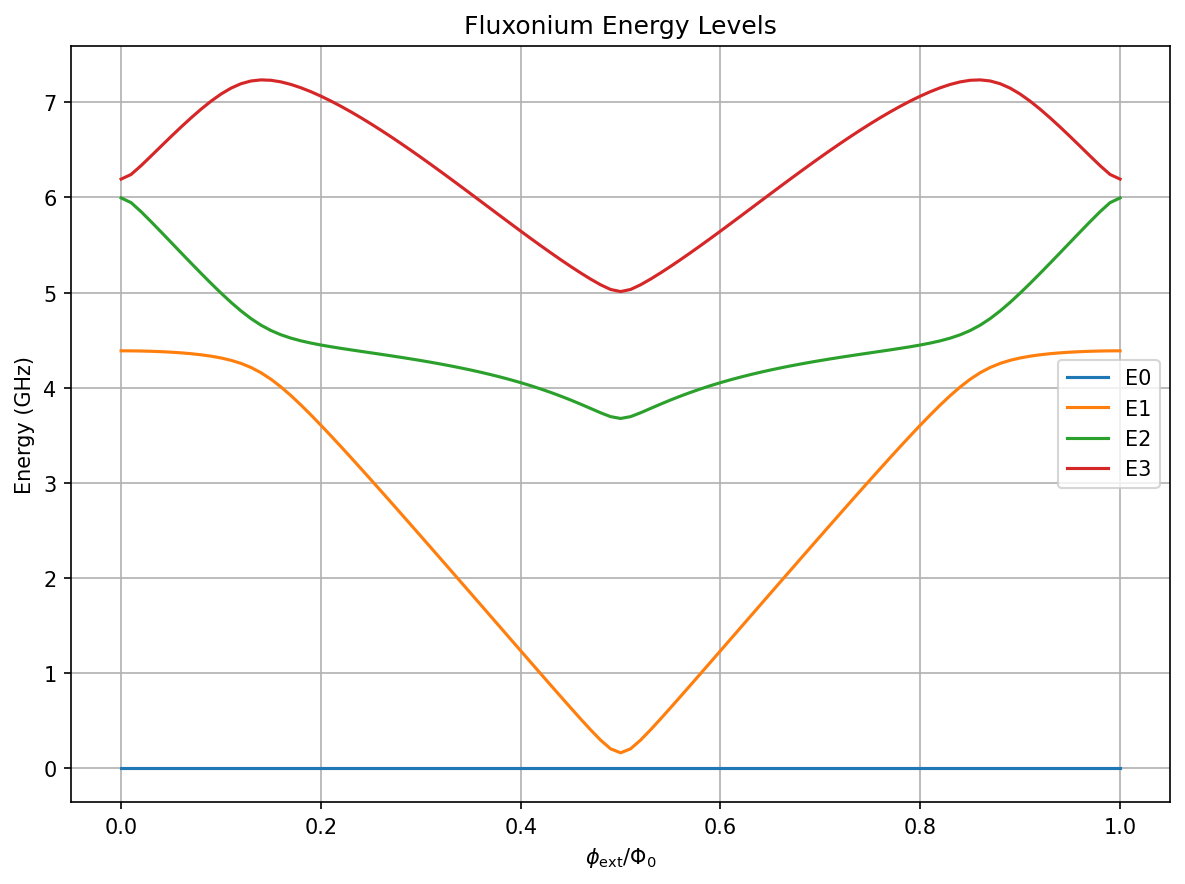

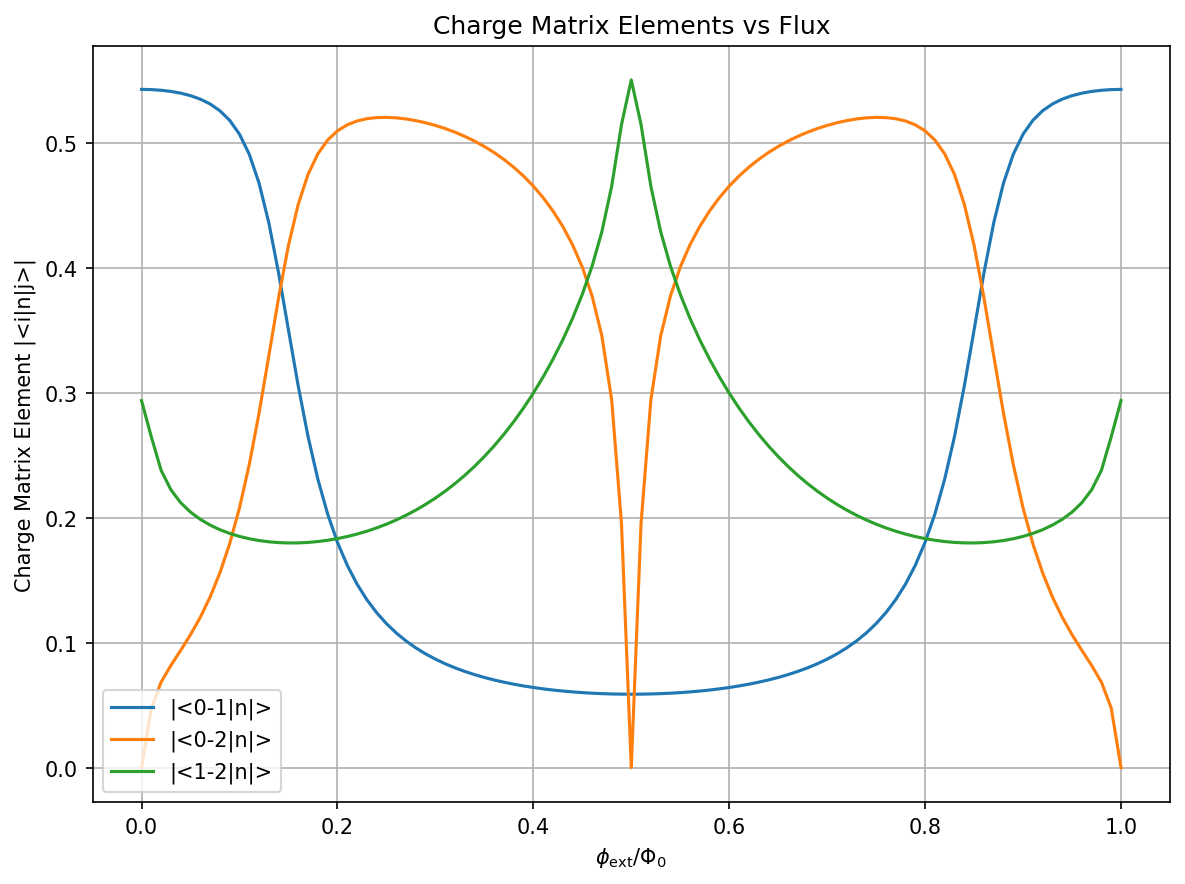

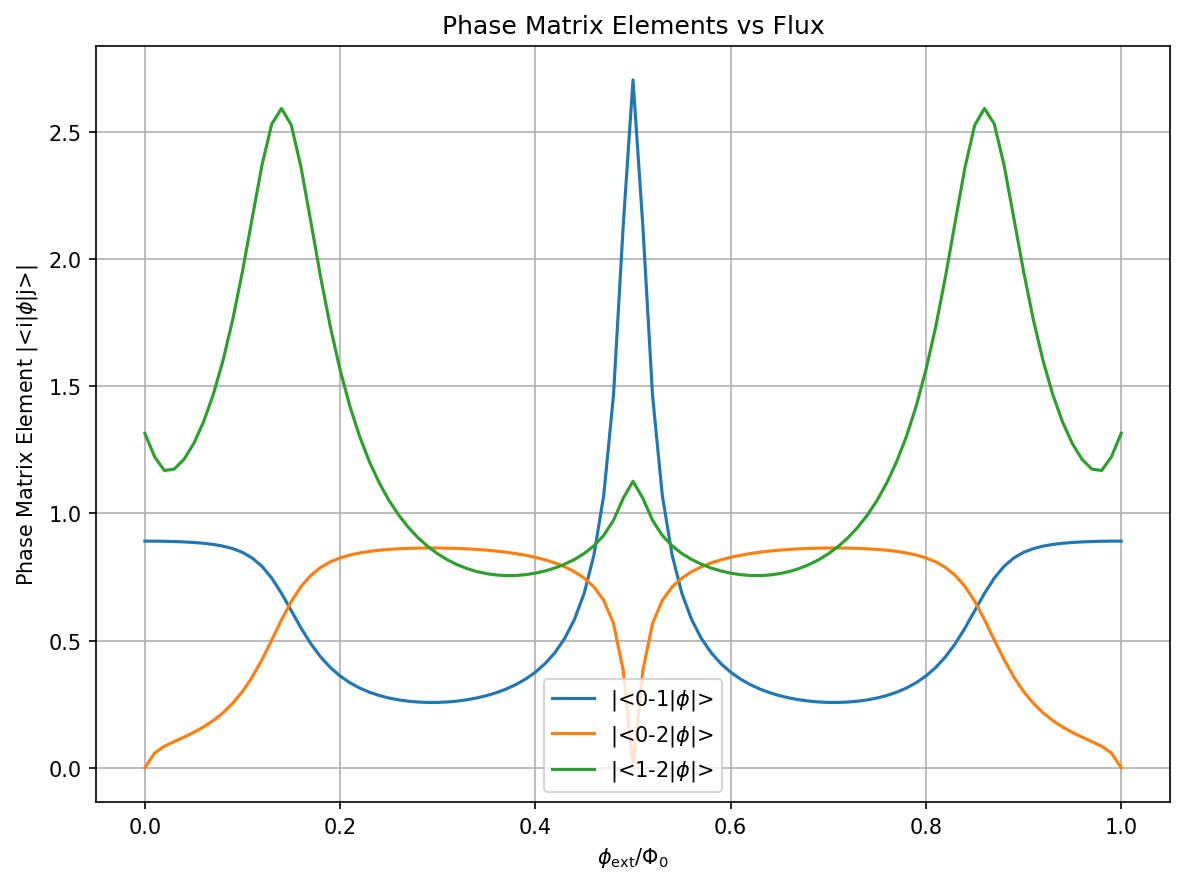

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from typing import Dict, Any

# Minimal Qubit base class for compatibility
# class Qubit:
#     """Base Qubit class (minimal implementation for compatibility)."""
#     def __init__(self, params: Dict[str, Any]):
#         self.params = params
#         self.ops = {}
#         self._eig_system = {}  # Initialize empty dictionary for eigenvalue system

# Fluxonium class (unchanged from previous response)
class Fluxonium(Qubit):
    """
    Fluxonium qubit class.
    
    Args:
        params (Dict): Dictionary of parameters defining the qubit
    
    On init:
        - Runs build_ops() function. All operators can be saved in dictionary self.ops
        - Generates empty results dictionary self._eig_system 
    """
    
    expected_params = ["Ej", "Ec", "El", "ng", "flux", "N_max_harm"]

    def __init__(self, params: Dict[str, Any]):
        # Initialize self.params for storing all system parameters
        self.params = params.copy()
        
        # Set default ng and flux if not specified
        if "ng" not in self.params:
            self.params["ng"] = 0.0
        if "flux" not in self.params:
            self.params["flux"] = 0.5
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = self.params["N_max_harm"]
        else:
            # Ensure energy eigenbasis dim is not greater than total harm basis dim
            assert self.params["N_max"] <= self.params["N_max_harm"]
        super().__init__(self.params)
        self._eig_system = {}  # Initialize _eig_system

    def build_ops(self):
        self.ops["n"] = self.calc_n_op()
        self.ops["phi"] = self.calc_phi_op()
        self.ops["Id_harm"] = qt.qeye(self.params["N_max_harm"])
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        phi_osc = (8 * self.params["Ec"] / self.params["El"]) ** 0.25
        a = qt.destroy(self.params["N_max_harm"])
        return 1j * (a.dag() - a) / (phi_osc * np.sqrt(2))

    def calc_phi_op(self):
        phi_osc = (8 * self.params["Ec"] / self.params["El"]) ** 0.25
        a = qt.destroy(self.params["N_max_harm"])
        return phi_osc * (a + a.dag()) / np.sqrt(2)
    
    def build_cos_op(self):
        phi = self.ops["phi"]
        Id = self.ops["Id_harm"]
        phi_ext = 2 * np.pi * self.params["flux"]
        arg = phi - phi_ext * Id
        return ( (1j * arg).expm() + (-1j * arg).expm() ) / 2
    
    @property
    def phi_zpf(self):
        Ec = self.params["Ec"]
        El = self.params["El"]
        return (8 * Ec / El) ** (1/4) / np.sqrt(2)
    
    @property
    def n_zpf(self):
        Ec = self.params["Ec"]
        El = self.params["El"]
        return 1 / (np.sqrt(2) * (8 * Ec / El) ** (1/4))
    
    def get_H(self):
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        El = self.params["El"]
        ng = self.params["ng"]
        return (
            4 * Ec * (self.ops["n"] - ng * self.ops["Id_harm"]) ** 2
            + 0.5 * El * self.ops["phi"] ** 2
            - Ej * self.build_cos_op()
        )

    @property
    def Ud(self):
        return qt.Qobj(self._eig_system.get('vecs', []))

    @property
    def H0(self):
        eigvals = self._eig_system.get('vals', [])
        if len(eigvals) > 0:
            eigvals = eigvals - eigvals[0]
        return qt.Qobj(np.diag(eigvals[:self.params["N_max"]]))

# Plotting Code (corrected)
# Parameters
params = {
    "Ec": 0.9,  # Charging energy in GHz
    "Ej": 3.73,  # Josephson energy in GHz
    "El": 0.36,  # Inductive energy in GHz
    "ng": 0.0,   # Charge offset
    "N_max_harm": 110  # Truncation for harmonic oscillator basis
}

# Flux points
flux_values = np.linspace(0, 1, 101)  # Reduced flux phi_ext/Phi_0 from 0 to 1

# Lists to store results
energies = []
n_matrix_elements = {'0-1': [], '0-2': [], '1-2': []}
phi_matrix_elements = {'0-1': [], '0-2': [], '1-2': []}

# Compute energies and matrix elements for each flux
for flux in flux_values:
    params['flux'] = flux
    fluxonium = Fluxonium(params)
    
    # Build operators and Hamiltonian
    fluxonium.build_ops()
    H = fluxonium.get_H()
    
    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = H.eigenstates()
    fluxonium._eig_system = {'vals': eigvals, 'vecs': eigvecs}  # Use new attribute
    
    # Normalize energies so ground state is zero
    normalized_energies = eigvals - eigvals[0]
    energies.append(normalized_energies[:4])  # Store first four energy levels
    
    # Compute matrix elements in the energy eigenbasis
    n_op = fluxonium.ops["n"]
    phi_op = fluxonium.ops["phi"]
    for i, j, label in [(0, 1, '0-1'), (0, 2, '0-2'), (1, 2, '1-2')]:
        if i < len(eigvecs) and j < len(eigvecs):
            psi_i = eigvecs[i]
            psi_j = eigvecs[j]
            # Charge matrix element <i|n|j>
            n_me = abs(psi_i.dag() * n_op * psi_j)  # Directly use the scalar value
            n_matrix_elements[label].append(n_me)
            # Phase matrix element <i|phi|j>
            phi_me = abs(psi_i.dag() * phi_op * psi_j)  # Directly use the scalar value
            phi_matrix_elements[label].append(phi_me)
        else:
            n_matrix_elements[label].append(0)
            phi_matrix_elements[label].append(0)

# Convert energies to array for plotting
energies = np.array(energies)

# Plot 1: Energy Levels
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(flux_values, energies[:, i], label=f'E{i}')
plt.xlabel(r'$\phi_{\text{ext}}/\Phi_0$')
plt.ylabel('Energy (GHz)')
plt.title('Fluxonium Energy Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('fluxonium_energy_levels.png')
plt.show()

# Plot 2: Charge Matrix Elements
plt.figure(figsize=(8, 6))
for label in ['0-1', '0-2', '1-2']:
    plt.plot(flux_values, n_matrix_elements[label], label=f'|<{label}|n|>')
plt.xlabel(r'$\phi_{\text{ext}}/\Phi_0$')
plt.ylabel('Charge Matrix Element |<i|n|j>|')
plt.title('Charge Matrix Elements vs Flux')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('fluxonium_charge_matrix_elements.png')
plt.show()

# Plot 3: Phase Matrix Elements
plt.figure(figsize=(8, 6))
for label in ['0-1', '0-2', '1-2']:
    plt.plot(flux_values, phi_matrix_elements[label], label=f'|<{label}|$\phi$|>')
plt.xlabel(r'$\phi_{\text{ext}}/\Phi_0$')
plt.ylabel('Phase Matrix Element |<i|$\phi$|j>|')
plt.title('Phase Matrix Elements vs Flux')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('fluxonium_phase_matrix_elements.png')
plt.show()

In [196]:
class DrivenQubit(DrivenSystem):
    """
    Driven qubit class for constructing Floquet Hamiltonian.

    Args:
        params (Dict): Dictionary of parameters defining the driven qubit
        qubit (Qubit): Bare quantum system (i.e. Transmon) object
        drive_coupling (qt.Qobj): Operator coupling to the drive. Note that 
                                  drive_coupling is NOT a composite operator
                                  and should have the dimension of the qubit.
    
    On init:
        - Runs build_ops_and_states()
        - Generates analysis dictionaries
    """
    expected_params = ["M_max"]
    
    # Build drive operators and states
    # ==========================================        
    def build_ops_and_states(self):
        """
        Method to construct drive operators in the extended Hilbert space.
        """
        M_max = self.params["M_max"]

        # Construct M = ∑ₘ m|m><m| operator in drive charge basis
        self.ops["M"] = qt.Qobj(np.diag(np.arange(-M_max, M_max + 1)))
        
        # Construct Id = ∑ₘ|m><m| in the drive charge basis
        self.ops["Id_drive"] = qt.Qobj(np.identity(2 * M_max + 1))

        # Construct M₊ and M₋ operators for drive
        self.ops["M-"] = qt.Qobj(np.eye(2 * M_max + 1, k=1))
        self.ops["M+"] = qt.Qobj(np.eye(2 * M_max + 1, k=-1))
        
        # Construct cos(θ) ≡ 1/2 * [M₊ + M₋] = 1/2 * ∑ₘ|m+1><m| + h.c
        self.ops["cos(θ)"] = 0.5 * (self.ops["M+"] + self.ops["M-"])

        # Construct |m=0⟩ Floquet mode, corresponding to zero drive photons.
        self.states["m=0"] = qt.basis(2 * M_max + 1, M_max)

        # Construct bare basis vectors and energies
        bare_eigvals, bare_eigvecs = self.qubit.H0.eigenstates()
        self.states["bare_basis"] = [qt.tensor(ev, self.states["m=0"]) for ev in bare_eigvecs]
        self.bare_energies = bare_eigvals
        
    
    # Effective Hamiltonian Definitions
    # ==========================================
    @property
    def H0(self):
        """
        Method to generate the bare system Hamiltonian H₀ ⊗ Id in the extended space
        """
        return qt.tensor(self.qubit.H0, self.ops["Id_drive"])
    
    @property
    def H_d(self):
        """
        Method to generate the operator part of the drive Hamiltonian H_d(t) in the extended 
        space. That is, for H_d(t) = Ω*Q*cos(ωt) and θ = ωt, we return Q ⊗ cos(θ). 
        
        Returns:
            Q ⊗ cos(θ) (qt.Qobj): Operator part of H_d; here Q is the drive_coupling.
        """
        return qt.tensor(self.ops["drive_coupling"], self.ops["cos(θ)"])
    
    def H_eff(self, omega: float, drive_amp: float):
        """
        Method to construct effective Hamiltonian H_eff = H₀ + H_d - i[∂/∂t] = H₀ + H_d + ωM
        in the extended space. 
        
        Args:
            omega (float): Drive frequency
            drive_amp (float): Drive amplitude 
        """
        M_composite = qt.tensor(self.qubit.ops["Id"], self.ops["M"])
        return self.H0 + (drive_amp * self.H_d) + (omega * M_composite)
    
    # Analysis
    # ==========================================
    def get_state_idxs(self, omega: float):
        """
        Method to get the indices of the basis states |α⟩⊗|m⟩ for all m, at zero drive amplitude
        Ω = 0. This is done by computing the closest energies to the known energies. 
        """
        M_max = self.params["M_max"]
        
        H_eff_0 = self.H_eff(omega, 0)
        eigvals, eigvecs = H_eff_0.eigenstates()

        idxs = {}
        for i, E in enumerate(self.bare_energies):
            for m in range(-M_max, M_max+1):
                idx_min = np.argmin(
                    [np.abs(E + m*omega - eigval) for eigval in eigvals]
                )
                idxs[(i, m)] = idx_min
                
        return idxs
    
    import numpy as np

    # Assuming this is added to your DrivenQubit class (self has access to bare_energies, params, H_eff)
    def get_state_idxs_tracked(self, omega: float, drive_amp: float, steps: np.ndarray):
        """
        Method to get the indices of the basis states |α⟩⊗|m⟩ for all m, at a given drive amplitude
        Ω ≠ 0, by tracking evolution step-by-step from amp=0.
        
        Args:
            omega: Drive frequency in GHz.
            drive_amp: Target drive amplitude in GHz.
            steps: Array of amplitude steps from 0 to drive_amp (inclusive).
        
        Returns:
            Dict[(int, int), int]: (alpha, m) -> index in eigstates at drive_amp.
        """
        M_max = self.params["M_max"]
        
        # Ensure steps include 0 and drive_amp, sorted ascending
        steps = np.unique(np.concatenate(([0, drive_amp], steps)))
        steps = np.sort(steps)
        
        # Step 1: Explicitly compute at amp=0 to get initial tracked energies (using your process)
        H_eff_0 = self.H_eff(omega, 0)
        evals_0, _ = H_eff_0.eigenstates()
        
        tracked_energies = {}
        for alpha, E_bare in enumerate(self.bare_energies):
            for m in range(-M_max, M_max + 1):
                diffs = np.abs([E_bare + m * omega - eval for eval in evals_0])
                idx_min = np.argmin(diffs)
                tracked_energies[(alpha, m)] = evals_0[idx_min]  # Use actual eval as starting point
        
        # Step 2: Track through remaining steps
        prev_evals = evals_0
        final_idxs = {}  # Will update at each step, return at end
        
        for amp in steps[1:]:  # Skip 0 since already done
            H_eff = self.H_eff(omega, amp)
            evals, _ = H_eff.eigenstates()
            
            for key, tracked_E in tracked_energies.items():
                diffs = np.abs(evals - tracked_E)
                idx_min = np.argmin(diffs)
                final_idxs[key] = idx_min
                # Update tracked energy for next step
                tracked_energies[key] = evals[idx_min]
            
            prev_evals = evals
        
        return final_idxs

In [258]:
params = {
    "Ec": 0.9,  # Charging energy in GHz
    "Ej": 3.73,  # Josephson energy in GHz
    "El": 0.36,  # Inductive energy in GHz
    "ng": 0.0,   # Charge offset
    "N_max_harm": 30,  # Truncation for harmonic oscillator basis
    "flux": 0.5,  # Reduced flux phi_ext/Phi_0
}
fluxonium = Fluxonium(params)
fluxonium.build_ops()
H = fluxonium.get_H()

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = H.eigenstates()
fluxonium._eig_system = {'vals': eigvals, 'vecs': eigvecs}  # Use new attribute

# Normalize energies so ground state is zero
normalized_energies = eigvals - eigvals[0]
drive_coupling = fluxonium.ops["n"]

In [252]:
normalized_energies

array([ 0.        ,  0.15655736,  3.67491613,  5.01019522,  7.51955893,
        9.65385034, 11.41851525, 12.23635902, 13.0521491 , 14.50836704,
       16.06315793, 17.59959637, 19.22781789, 20.96108742, 22.078895  ,
       22.77998589, 24.90884967, 26.51720416, 29.12635584, 30.06121435,
       31.95775772, 33.51146002, 35.51132353, 35.85571421, 38.56990587,
       38.80497577, 40.71315883, 42.9627202 , 44.85865338, 46.40152277])

In [259]:
# Set up the Floquet qubit
M_max = 15
fq = DrivenQubit({"M_max": M_max}, fluxonium, drive_coupling)

In [238]:
fq.bare_energies
ω01 = fq.bare_energies[1]-fq.bare_energies[0]
ω12 = fq.bare_energies[2]-fq.bare_energies[1]
ω01


np.float64(0.15655736492911387)

In [239]:
# Drive frequency
ωd = ω12 + 300 * MHz
H_eff_0 = fq.H_eff(ωd, 0)

eigvals, eigvecs = H_eff_0.eigenstates()

idxs = {}
for alpha, E_alpha in enumerate(fq.bare_energies):
    for m in range(-M_max, M_max+1):
        idx_min = np.argmin(
            [np.abs(E_alpha + m*ωd - eigval) for eigval in eigvals]
        )
        idxs[(alpha, m)] = idx_min

In [240]:
M_plus = qt.tensor(fq.qubit.ops["Id"], fq.ops["M+"])
M_min = qt.tensor(fq.qubit.ops["Id"], fq.ops["M-"])

In [203]:
eigvecs[idxs[(1, 1)]].dag() * M_plus * eigvecs[idxs[(0, 0)]]
idxs[(1,0)]

np.int64(39)

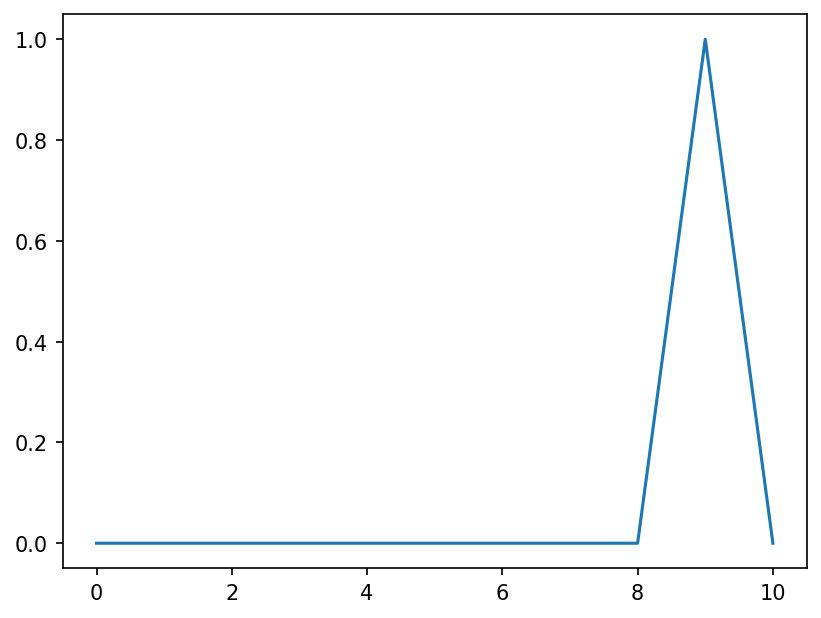

In [204]:
# Verify the properties here 
overlaps = [np.abs(M_plus.matrix_element(eigvecs[idxs[(0, 5)]], eigvecs[idxs[(0, m)]])) for m in range(-M_max, M_max + 1)]

plt.plot(overlaps)

In [ ]:
# ### New Code for Plotting
# drive_amps = np.linspace(0, 0.75, 106)
# drive_freq = ω01 + 200*MHz 

# idxs = fq.get_state_idxs_tracked(drive_freq, 0.5, drive_amps)
# bare_basis_idxs = [idxs[(alpha, 0)] for alpha, _ in enumerate(fq.bare_energies)]

# # Additional array of all quasi-energies
# all_quasi_energies = []

# total_energies = []
# total_states = []
# for drive_amp in drive_amps:
    
#     H_eff = fq.H_eff(drive_freq, drive_amp)
#     eigvals, eigvecs = H_eff.eigenstates()
    
#     energies = eigvals[bare_basis_idxs]
#     states = eigvecs[bare_basis_idxs]
    
#     total_energies.append(energies)
#     total_states.append(states)
#     all_quasi_energies.append(eigvals)
    
# total_energies = np.array(total_energies)
# all_quasi_energies = np.array(all_quasi_energies)

In [241]:
#  old code

### Code for Plotting
drive_amps = np.linspace(0, 1, 106)
drive_freq = ω01 + 200*MHz

idxs = fq.get_state_idxs(drive_freq)
bare_basis_idxs = [idxs[(alpha, 0)] for alpha, _ in enumerate(fq.bare_energies)]

# Additional array of all quasi-energies
all_quasi_energies = []

total_energies = []
total_states = []
for drive_amp in drive_amps:
    
    H_eff = fq.H_eff(drive_freq, drive_amp)
    eigvals, eigvecs = H_eff.eigenstates()
    
    energies = eigvals[bare_basis_idxs]
    states = eigvecs[bare_basis_idxs]
    
    total_energies.append(energies)
    total_states.append(states)
    all_quasi_energies.append(eigvals)
    
total_energies = np.array(total_energies)
all_quasi_energies = np.array(all_quasi_energies)

In [242]:
# Extract the qubit frequencies and anharmonicities
qubit_freqs_21 = total_energies[:, 2] - total_energies[:, 1]
qubit_freqs_10 = total_energies[:, 1] - total_energies[:, 0]
anharms = total_energies[:, 2] + total_energies[:, 0] - 2*total_energies[:, 1]

Text(0.5, 1.0, 'Floquet Quasi-Energy Spectrum')

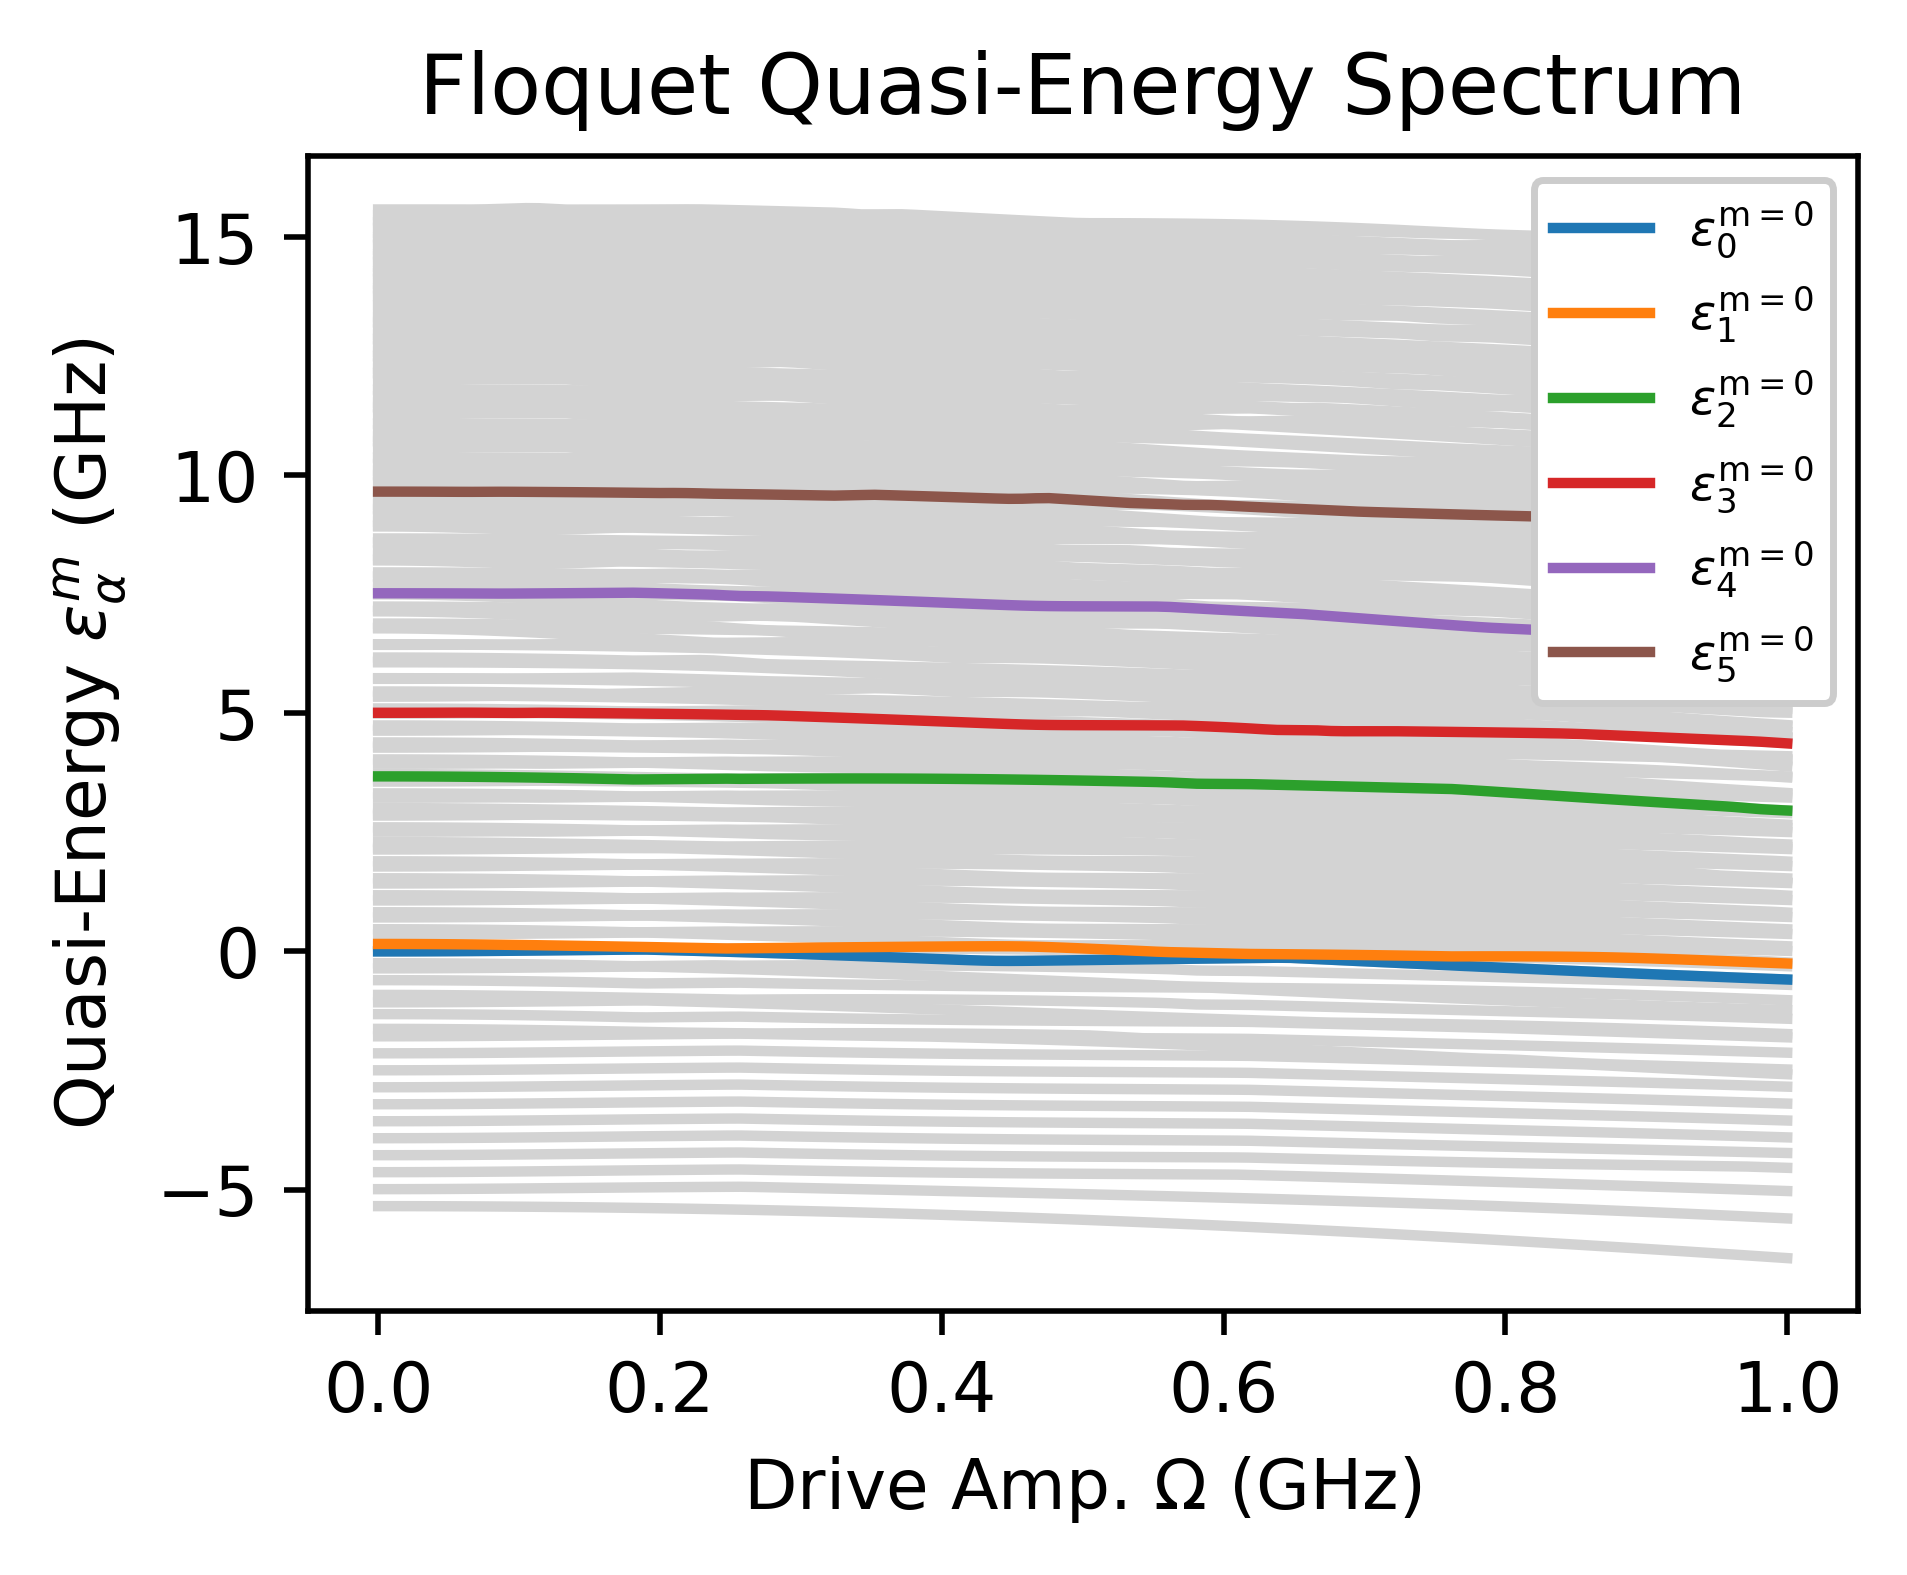

In [243]:
plt.figure(figsize=(4, 3), dpi=500)
for n in range(0, 310, 2):
    plt.plot(drive_amps, all_quasi_energies[:, n], color="lightgrey")

for n in range(6):
    plt.plot(drive_amps, total_energies[:, n], label=fr"$\epsilon_{n}^{{\rm m=0}}$")

plt.legend(loc="upper right", fontsize=7, framealpha=1)
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Quasi-Energy $\epsilon_{\alpha}^{m}$ (GHz)")
plt.title("Floquet Quasi-Energy Spectrum")

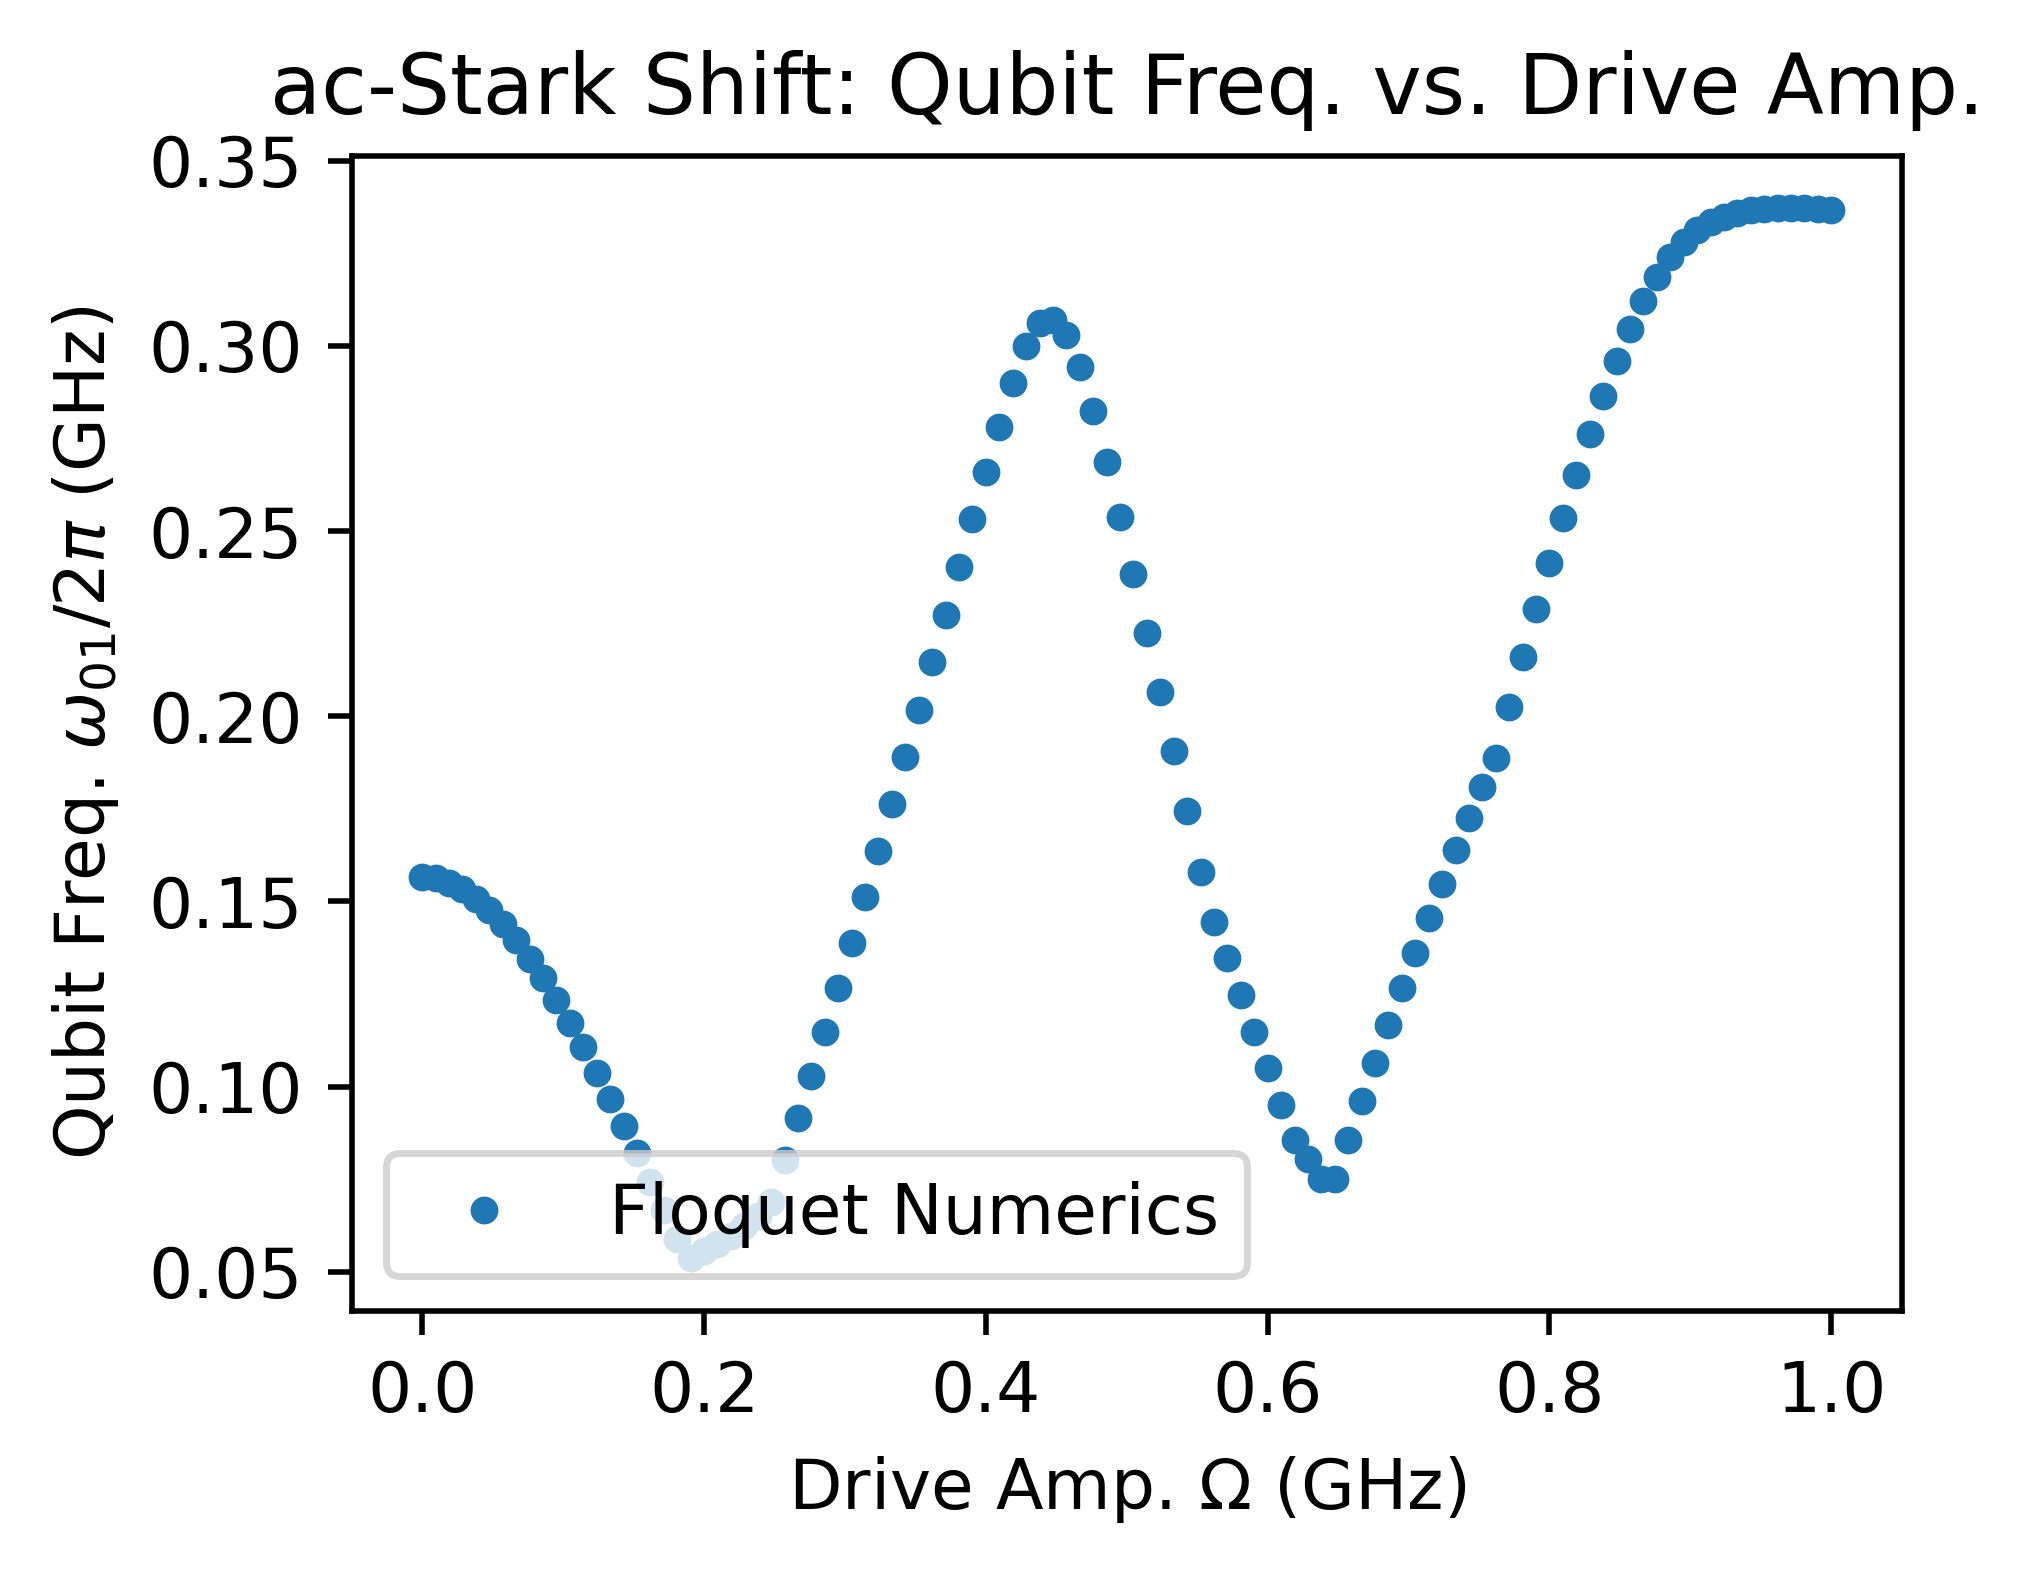

In [244]:
plt.figure(figsize=(4, 3), dpi=500)
plt.plot(drive_amps, qubit_freqs_10, '.', label="Floquet Numerics")
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Qubit Freq. $\omega_{\rm 01}/2\pi$ (GHz)")
plt.title(r"ac-Stark Shift: Qubit Freq. vs. Drive Amp.")


plt.legend(loc="lower left")

# _ = fq.qubit.qubit_report()

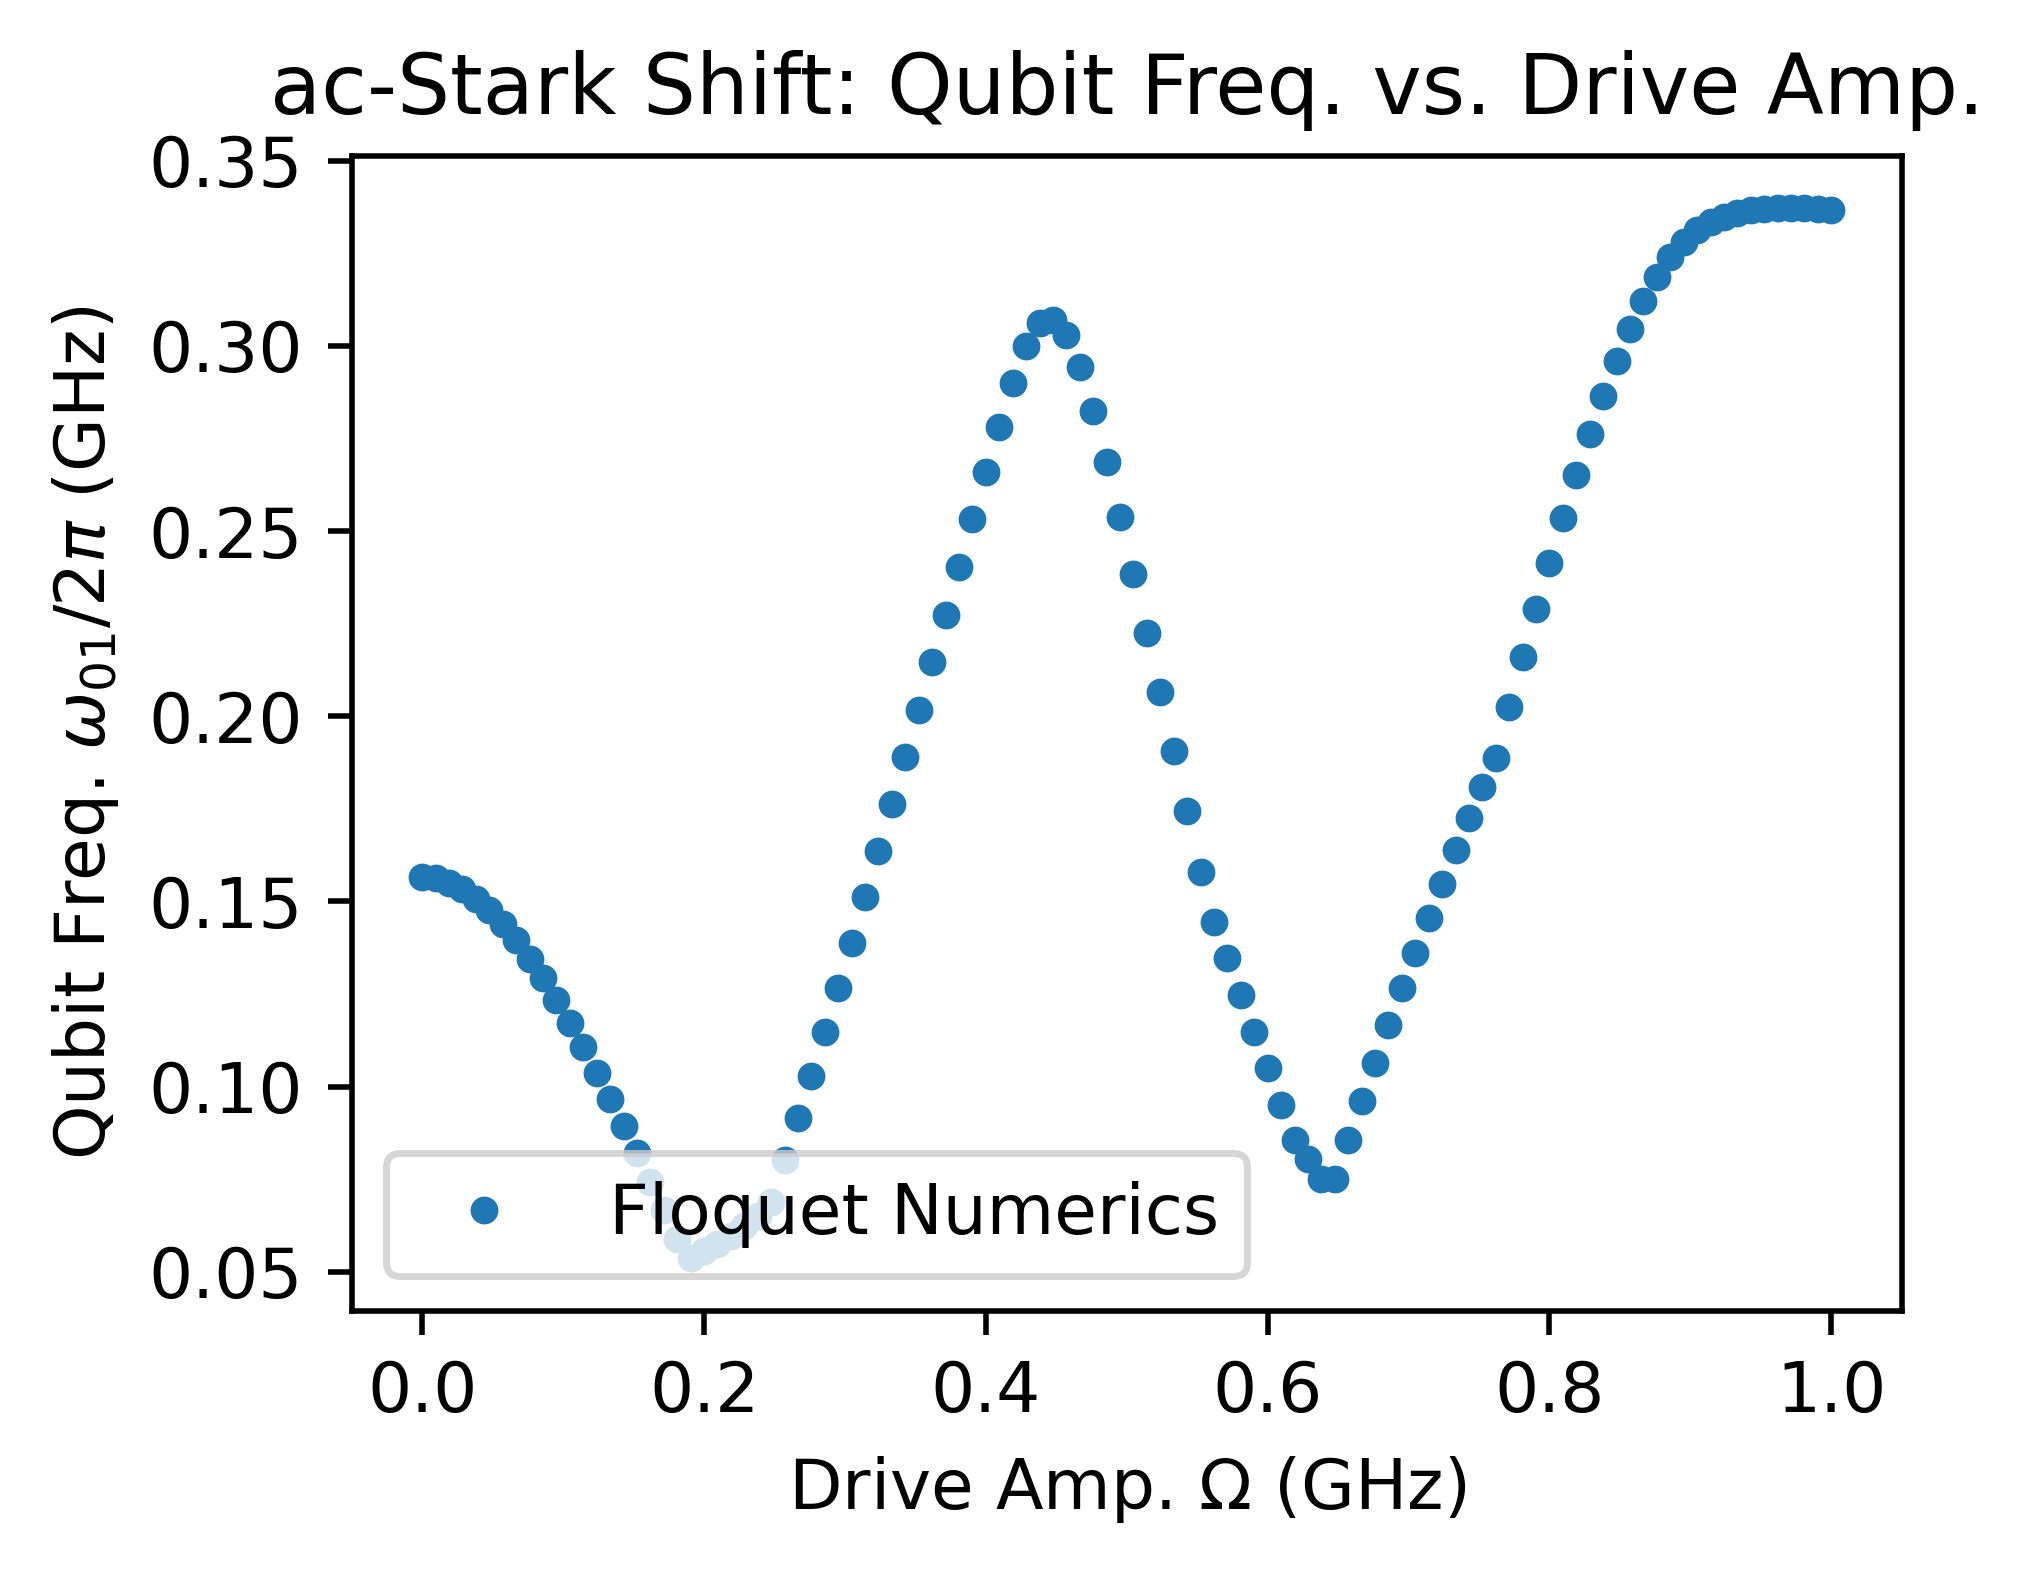

In [245]:
plt.figure(figsize=(4, 3), dpi=500)
plt.plot(drive_amps, qubit_freqs_10, '.', label="Floquet Numerics")
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Qubit Freq. $\omega_{\rm 01}/2\pi$ (GHz)")
plt.title(r"ac-Stark Shift: Qubit Freq. vs. Drive Amp.")


plt.legend(loc="lower left")

# _ = fq.qubit.qubit_report()

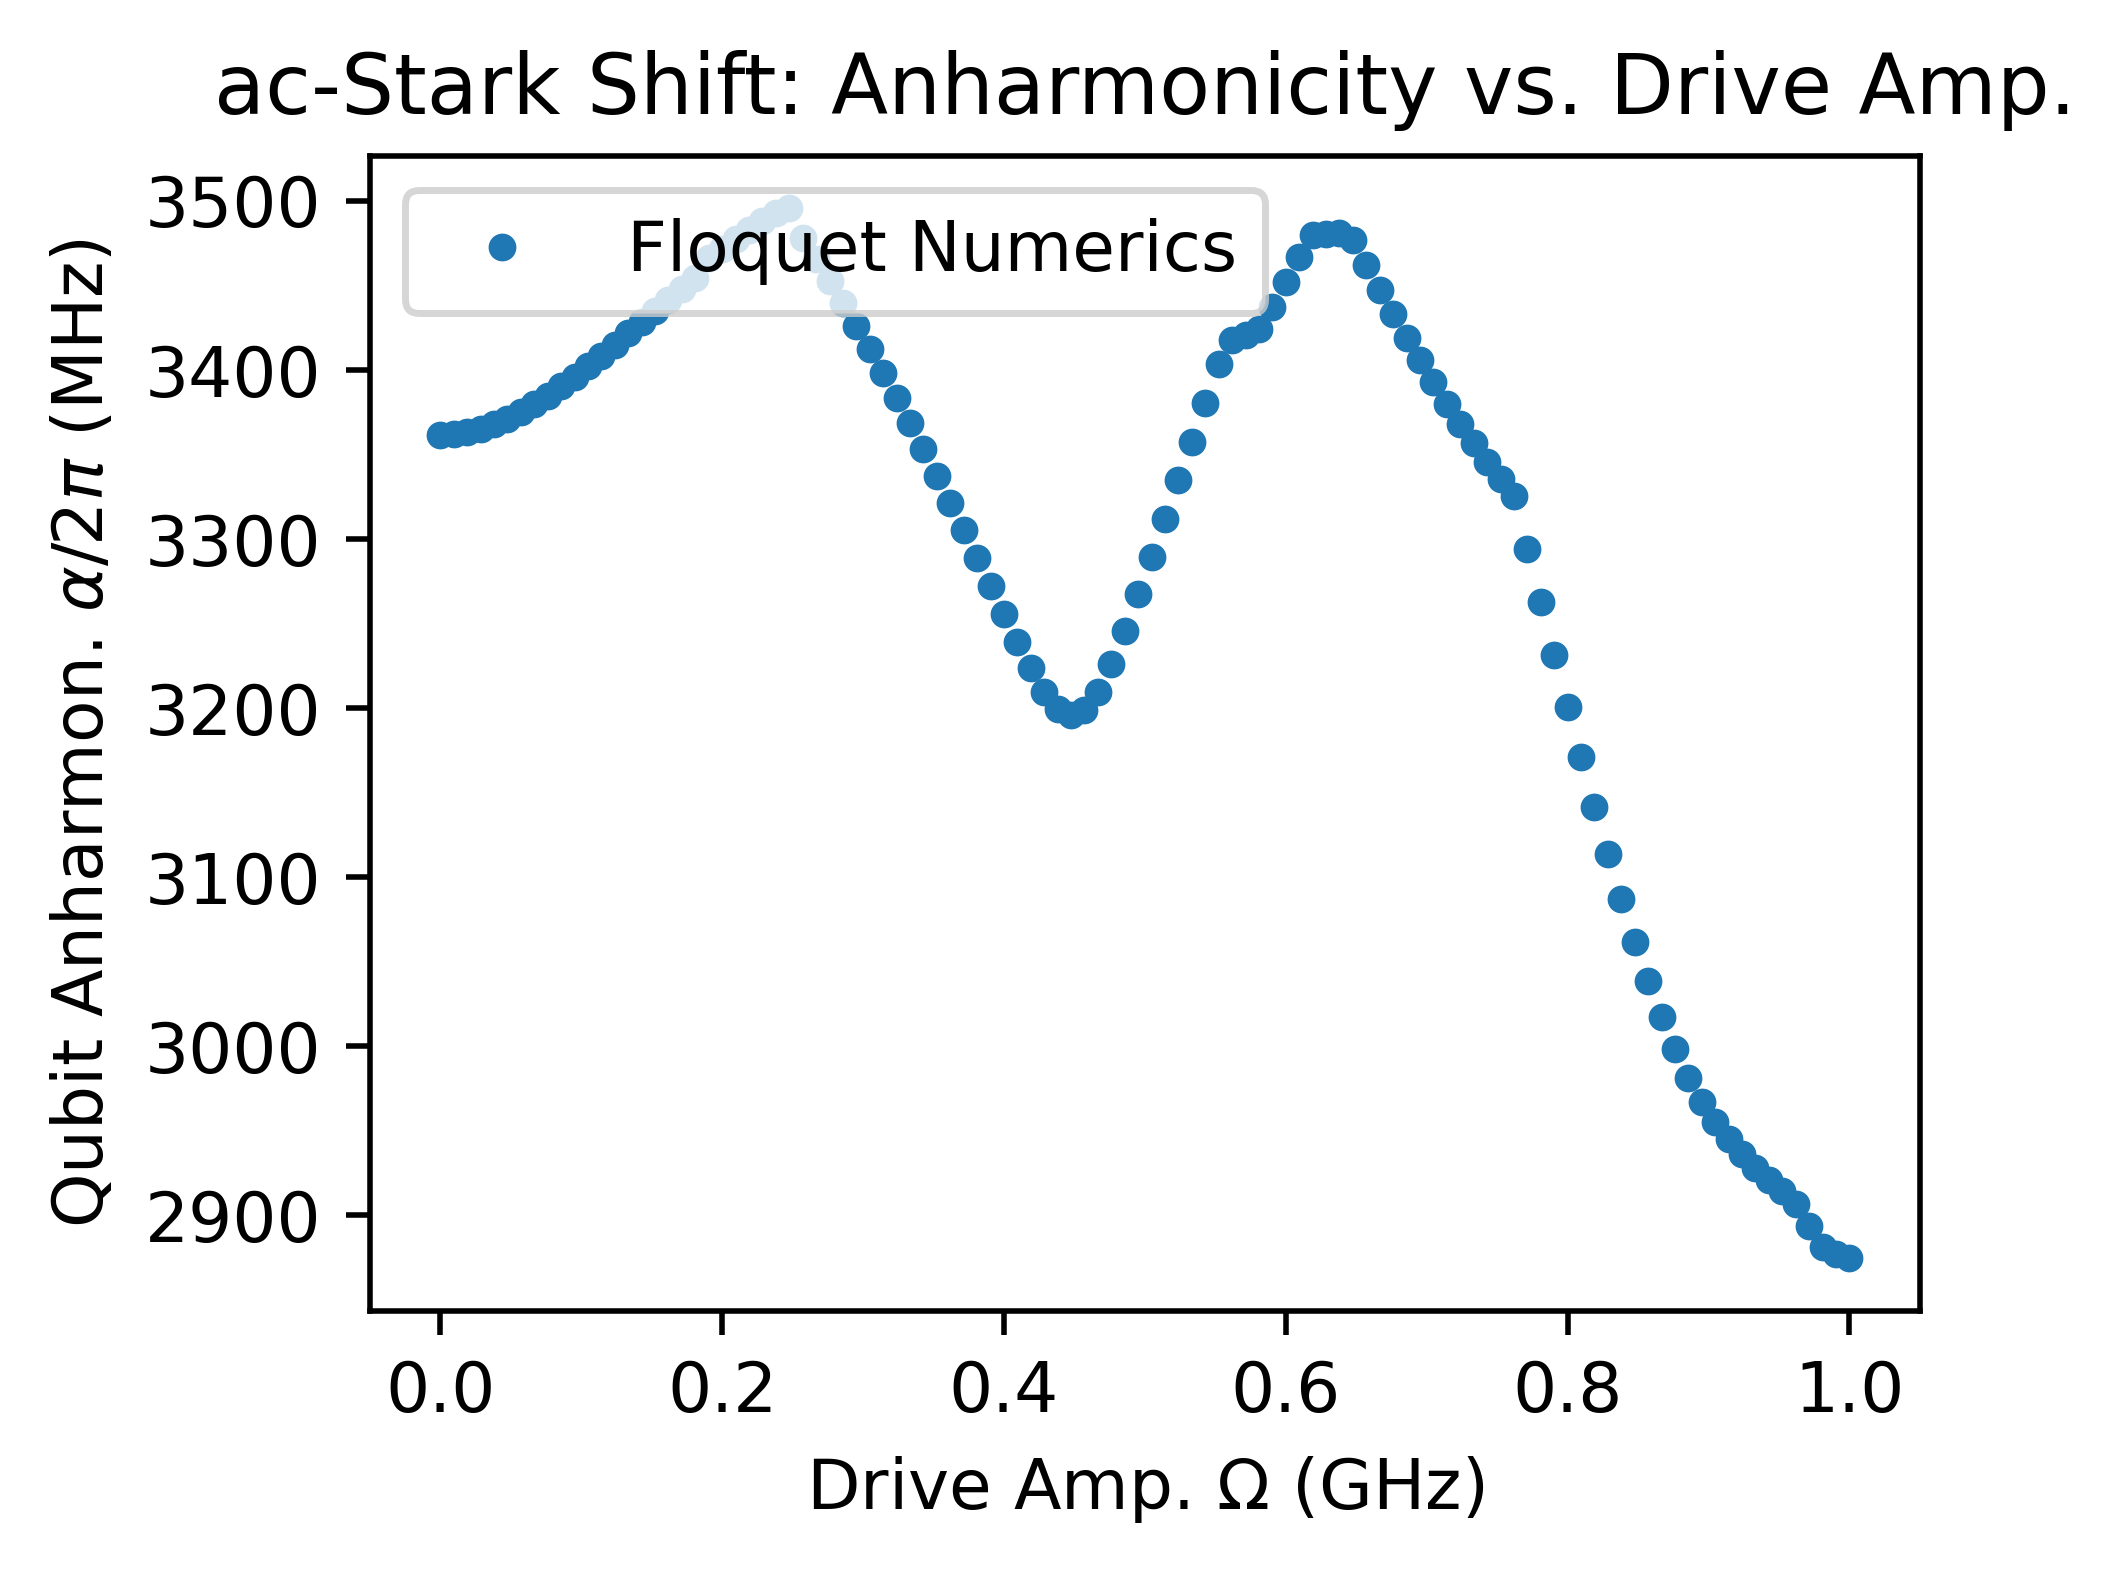

In [246]:
plt.figure(figsize=(4, 3), dpi=500)
plt.plot(drive_amps, anharms / MHz, '.', label="Floquet Numerics")
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Qubit Anharmon. $\alpha/2\pi$ (MHz)")
plt.title(r"ac-Stark Shift: Anharmonicity vs. Drive Amp.")
plt.legend(loc="upper left")


# _ = fq.qubit.qubit_report()


plt.show()

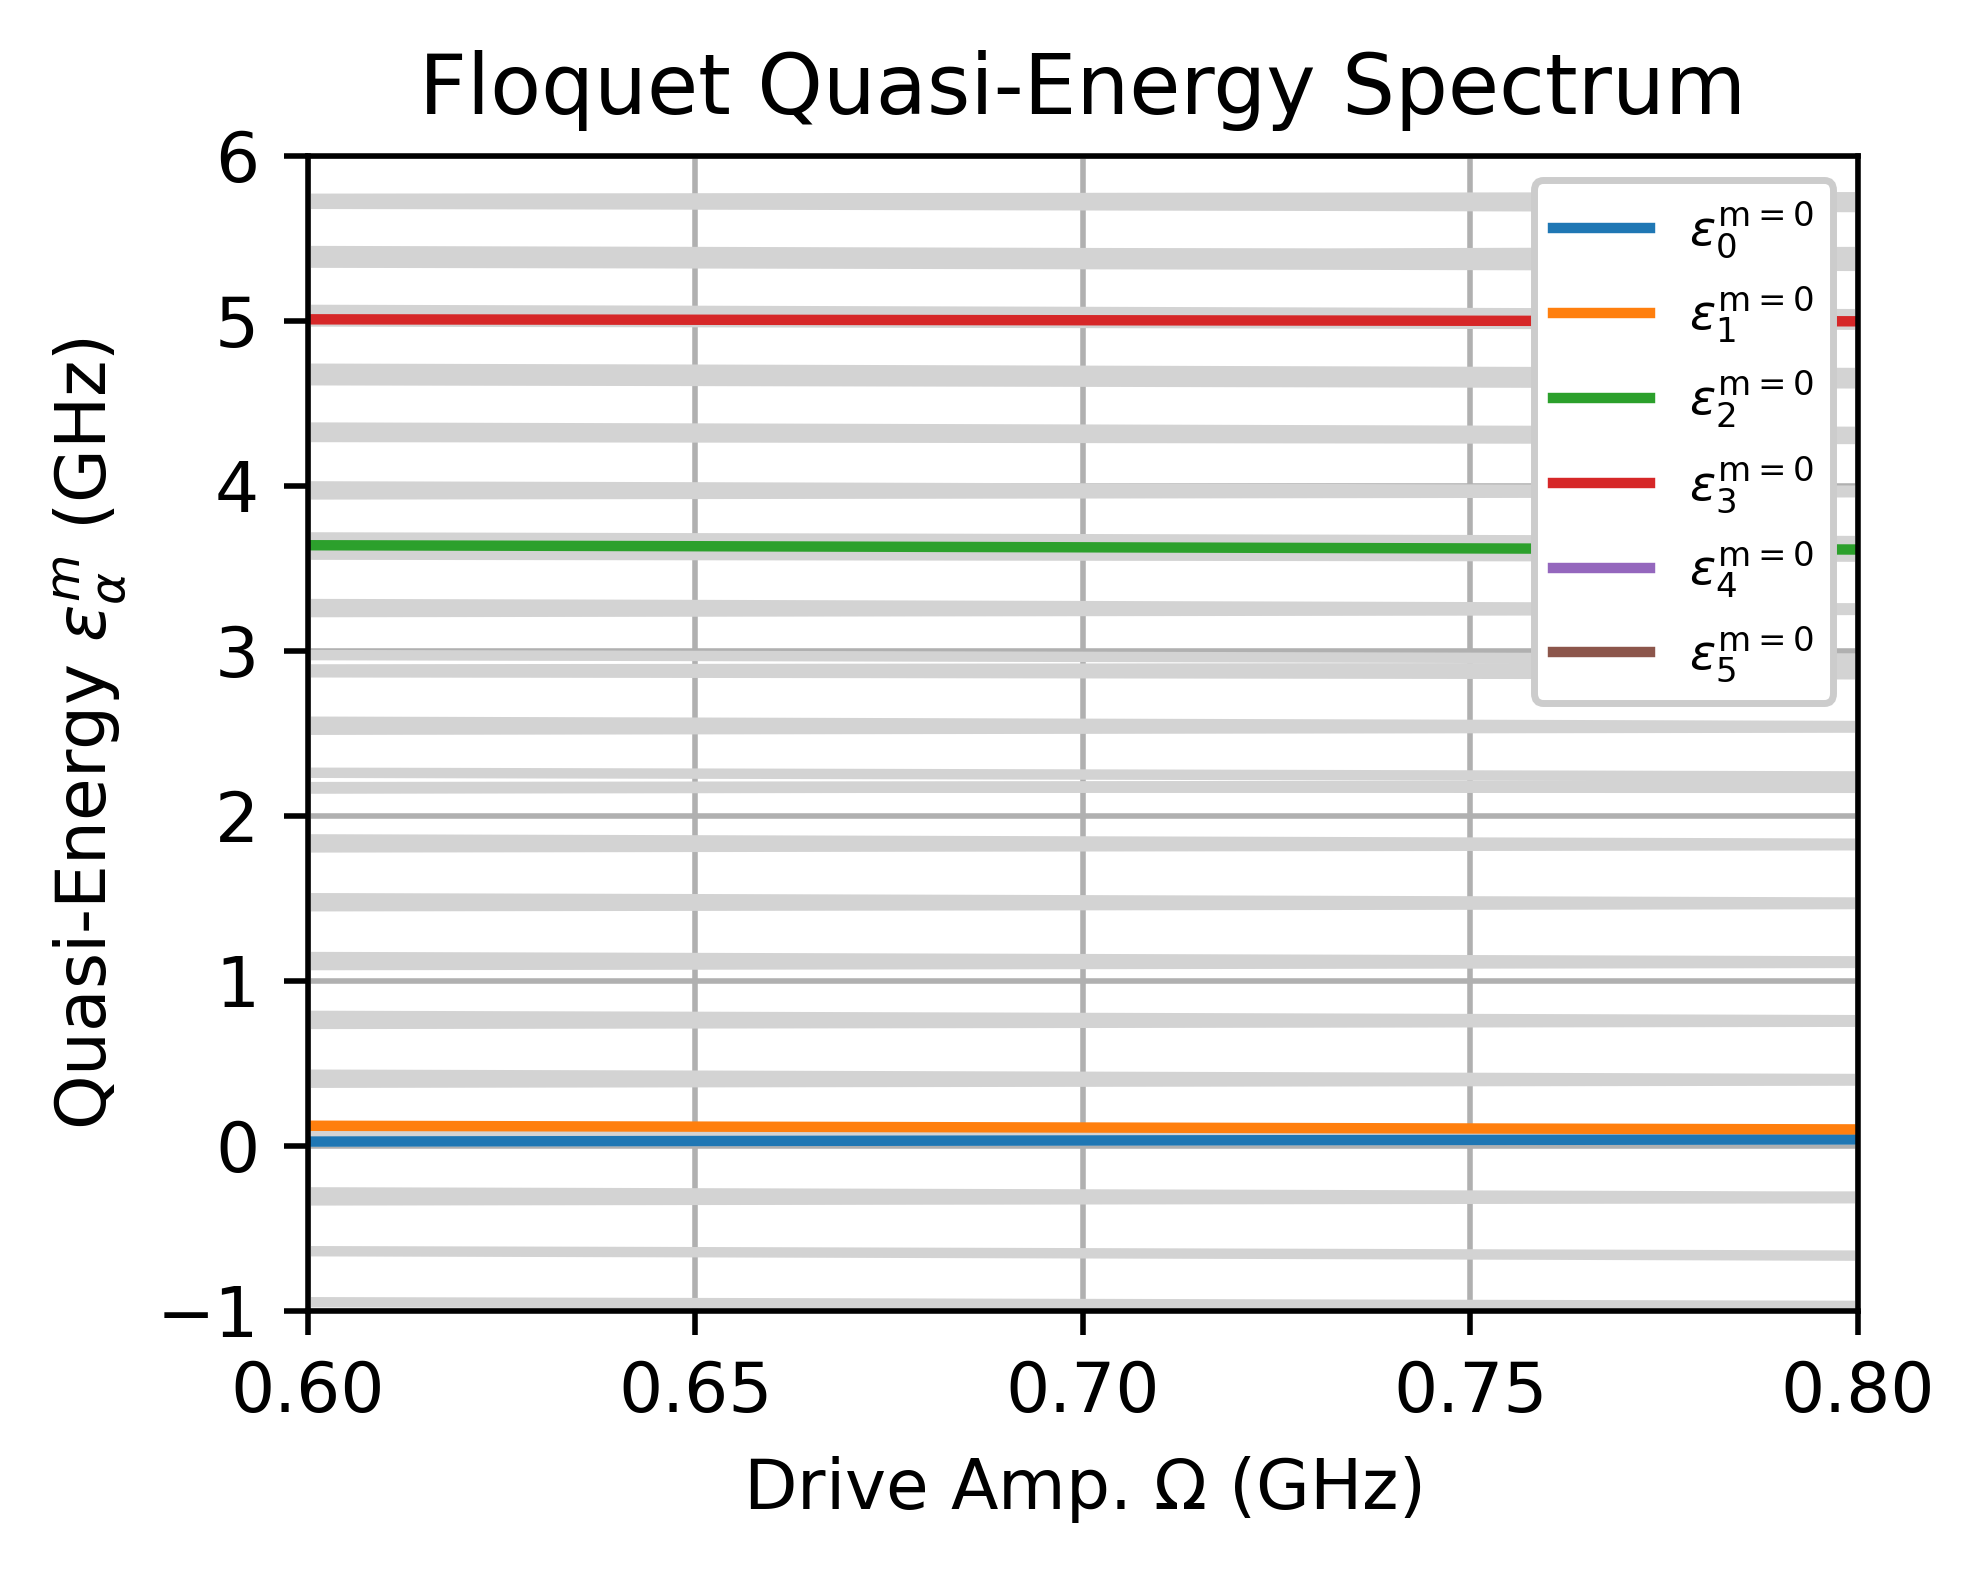

In [ ]:
# new code to track the energy levels
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Your setup (adjust if needed)
drive_amps = np.linspace(0, 6, 206)
drive_freq = ω01 + 200*MHz

M_max = fq.params["M_max"]
num_alpha = len(fq.bare_energies)
num_overlay_alpha = 6  # Overlay alpha=0 to 5, m=0

# Initialize tracked energies at amp=0
H_eff_0 = fq.H_eff(drive_freq, 0)
evals_0, _ = H_eff_0.eigenstates()

tracked_energies = {}
for alpha, E_bare in enumerate(fq.bare_energies):
    for m in range(-M_max, M_max + 1):
        diffs = np.abs([E_bare + m * drive_freq - eval for eval in evals_0])
        idx_min = np.argmin(diffs)
        tracked_energies[(alpha, m)] = evals_0[idx_min]

# Storage
total_energies = np.zeros((len(drive_amps), num_overlay_alpha))  # For overlay: m=0, alpha=0-5
total_energies[0] = [tracked_energies[(alpha, 0)] for alpha in range(num_overlay_alpha)]
all_quasi_energies = [evals_0]  # Full spectrum

# Loop: Track and collect
for i_amp, drive_amp in enumerate(drive_amps[1:], start=1):
    H_eff = fq.H_eff(drive_freq, drive_amp)
    evals, _ = H_eff.eigenstates()  # No need for evecs unless states wanted
    
    # Update tracked
    for key in tracked_energies:
        tracked_E = tracked_energies[key]
        diffs = np.abs(evals - tracked_E)
        idx_min = np.argmin(diffs)
        tracked_energies[key] = evals[idx_min]
    
    # Collect
    total_energies[i_amp] = [tracked_energies[(alpha, 0)] for alpha in range(num_overlay_alpha)]
    all_quasi_energies.append(evals)

all_quasi_energies = np.array(all_quasi_energies)

qubit_freqs = total_energies[:, 2] - total_energies[:, 1]

# Plot like yours: Full spectrum in grey (every other, up to min(310, dim))
dim = all_quasi_energies.shape[1]  # Full dim
max_n = min(310, dim)
plt.figure(figsize=(4, 3), dpi=500)
for n in range(0, max_n, 2):
    plt.plot(drive_amps, all_quasi_energies[:, n], color="lightgrey")

for n in range(num_overlay_alpha):
    plt.plot(drive_amps, total_energies[:, n], label=fr"$\epsilon_{{{n}}}^{{\rm m=0}}$")

plt.legend(loc="upper right", fontsize=7, framealpha=1)
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Quasi-Energy $\epsilon_{\alpha}^{m}$ (GHz)")
plt.title("Floquet Quasi-Energy Spectrum")
plt.ylim(-1, 6)
# plt.xlim(0.6, 0.8)
plt.grid(True)
plt.show()

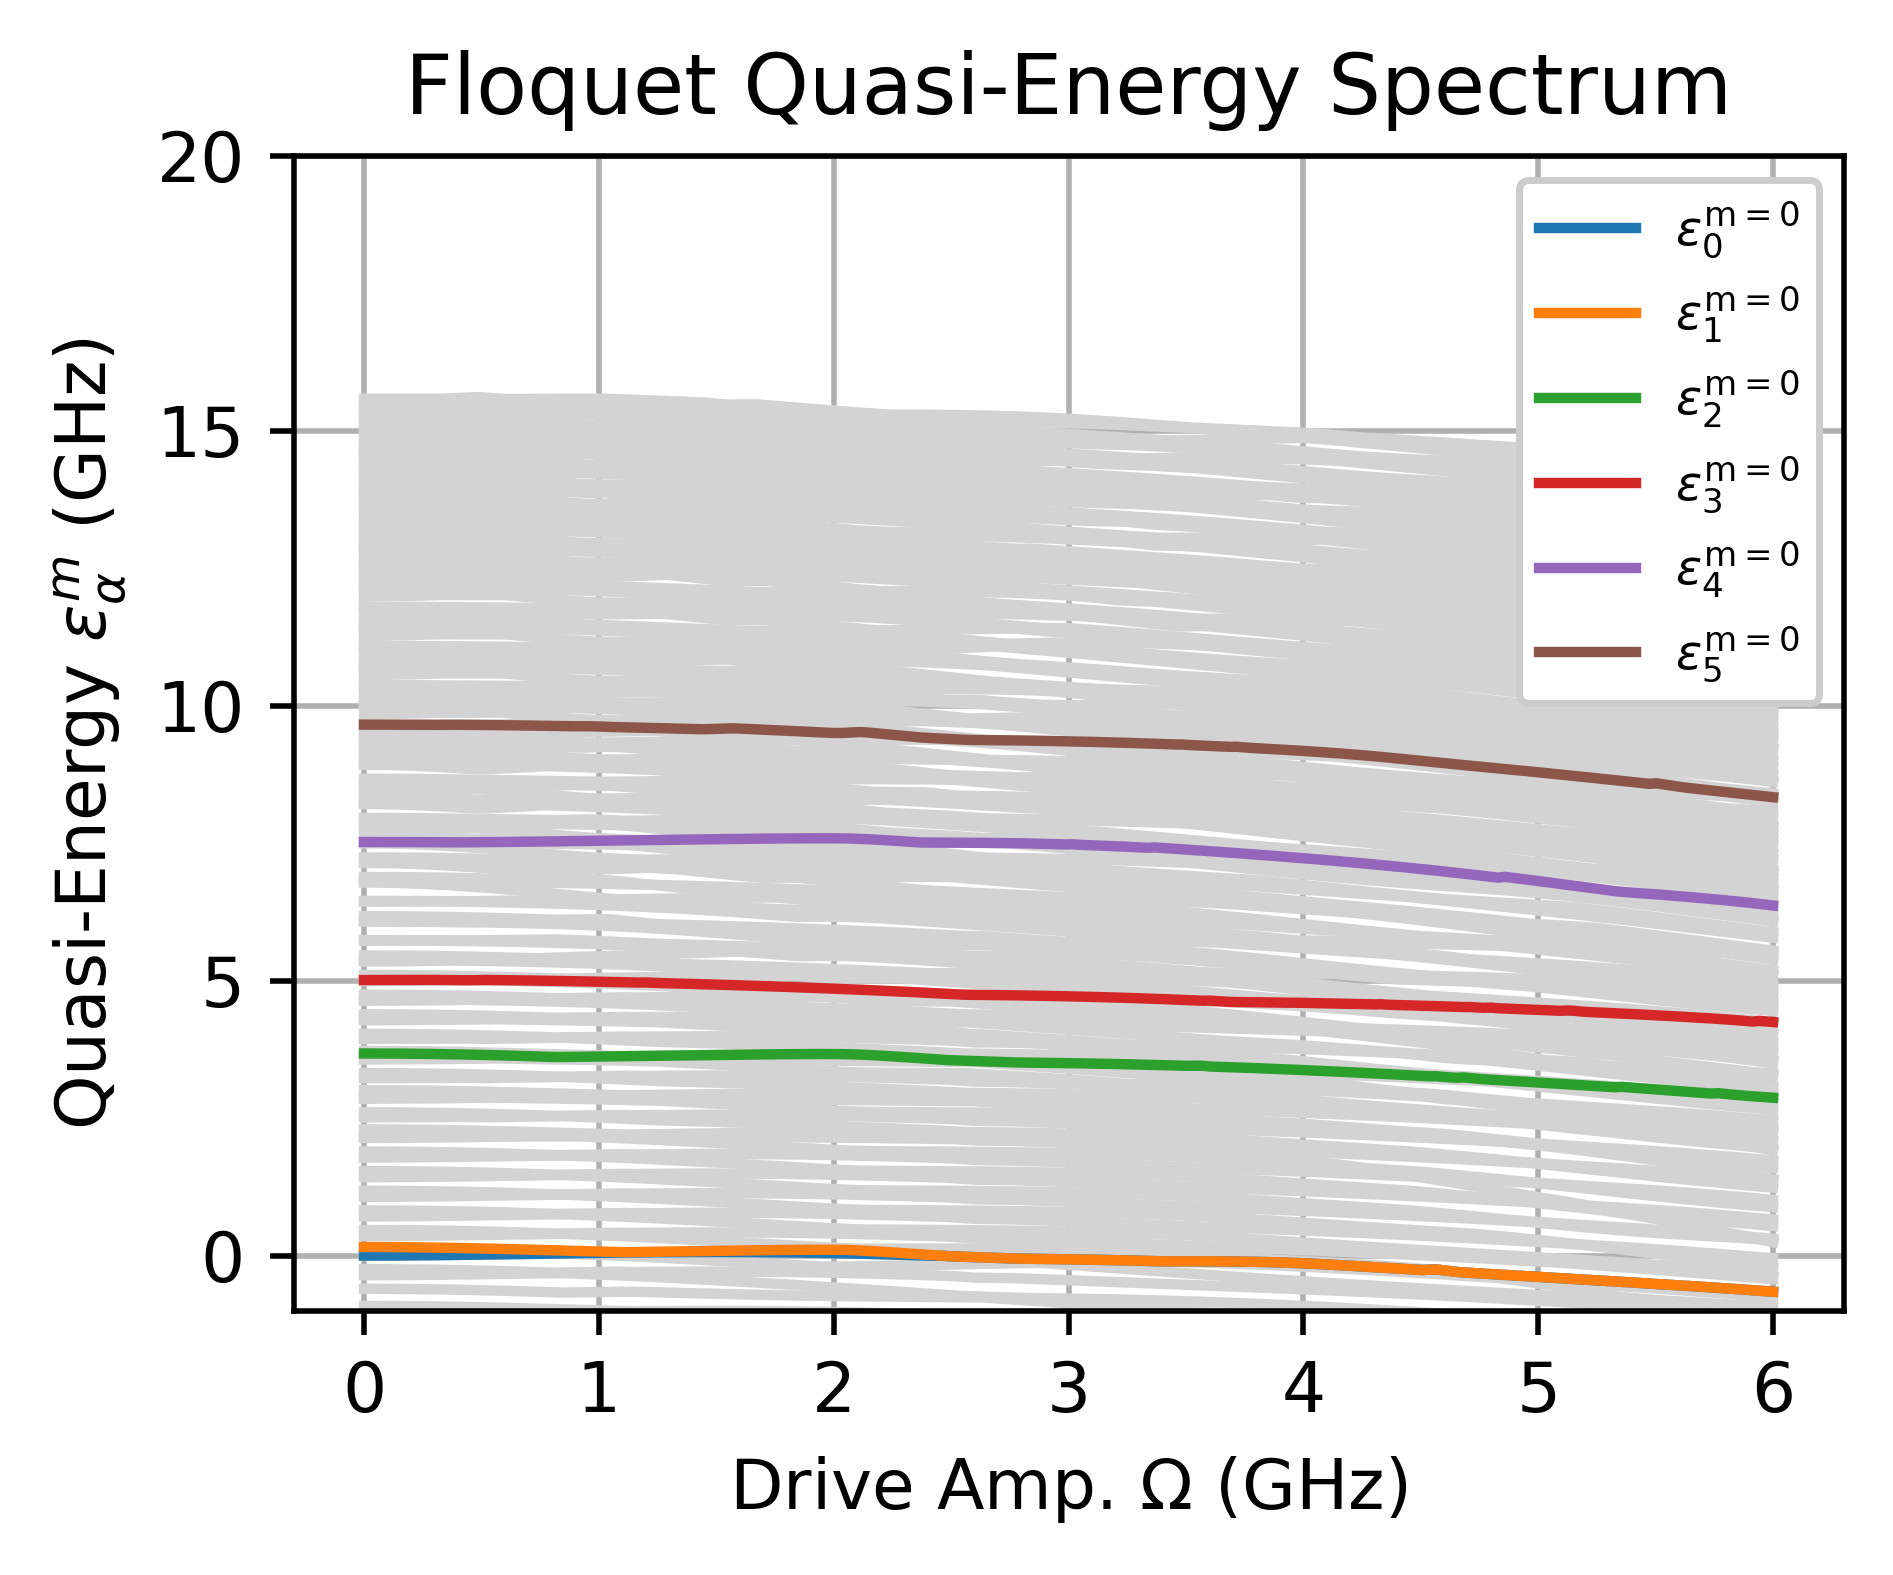

In [265]:
# Plot like yours: Full spectrum in grey (every other, up to min(310, dim))
dim = all_quasi_energies.shape[1]  # Full dim
max_n = min(310, dim)
plt.figure(figsize=(4, 3), dpi=500)
for n in range(0, max_n, 2):
    plt.plot(drive_amps, all_quasi_energies[:, n], color="lightgrey")

for n in range(num_overlay_alpha):
    plt.plot(drive_amps, total_energies[:, n], label=fr"$\epsilon_{{{n}}}^{{\rm m=0}}$")

plt.legend(loc="upper right", fontsize=7, framealpha=1)
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Quasi-Energy $\epsilon_{\alpha}^{m}$ (GHz)")
plt.title("Floquet Quasi-Energy Spectrum")
plt.ylim(-1, 20)
# plt.xlim(0.6, 0.8)
plt.grid(True)
plt.show()

In [262]:
# Compute ac-Stark shift and anharmonicity
omega_01_bare = fq.bare_energies[1] - fq.bare_energies[0]  # Bare 0-1 frequency
omega_01 = total_energies[:, 1] - total_energies[:, 0]  # Driven 0-1 frequency
omega_12 = total_energies[:, 2] - total_energies[:, 1]  # Driven 1-2 frequency
ac_stark_shift = omega_01   # Shift from bare value
anharmonicity = omega_12 - omega_01  # Anharmonicity

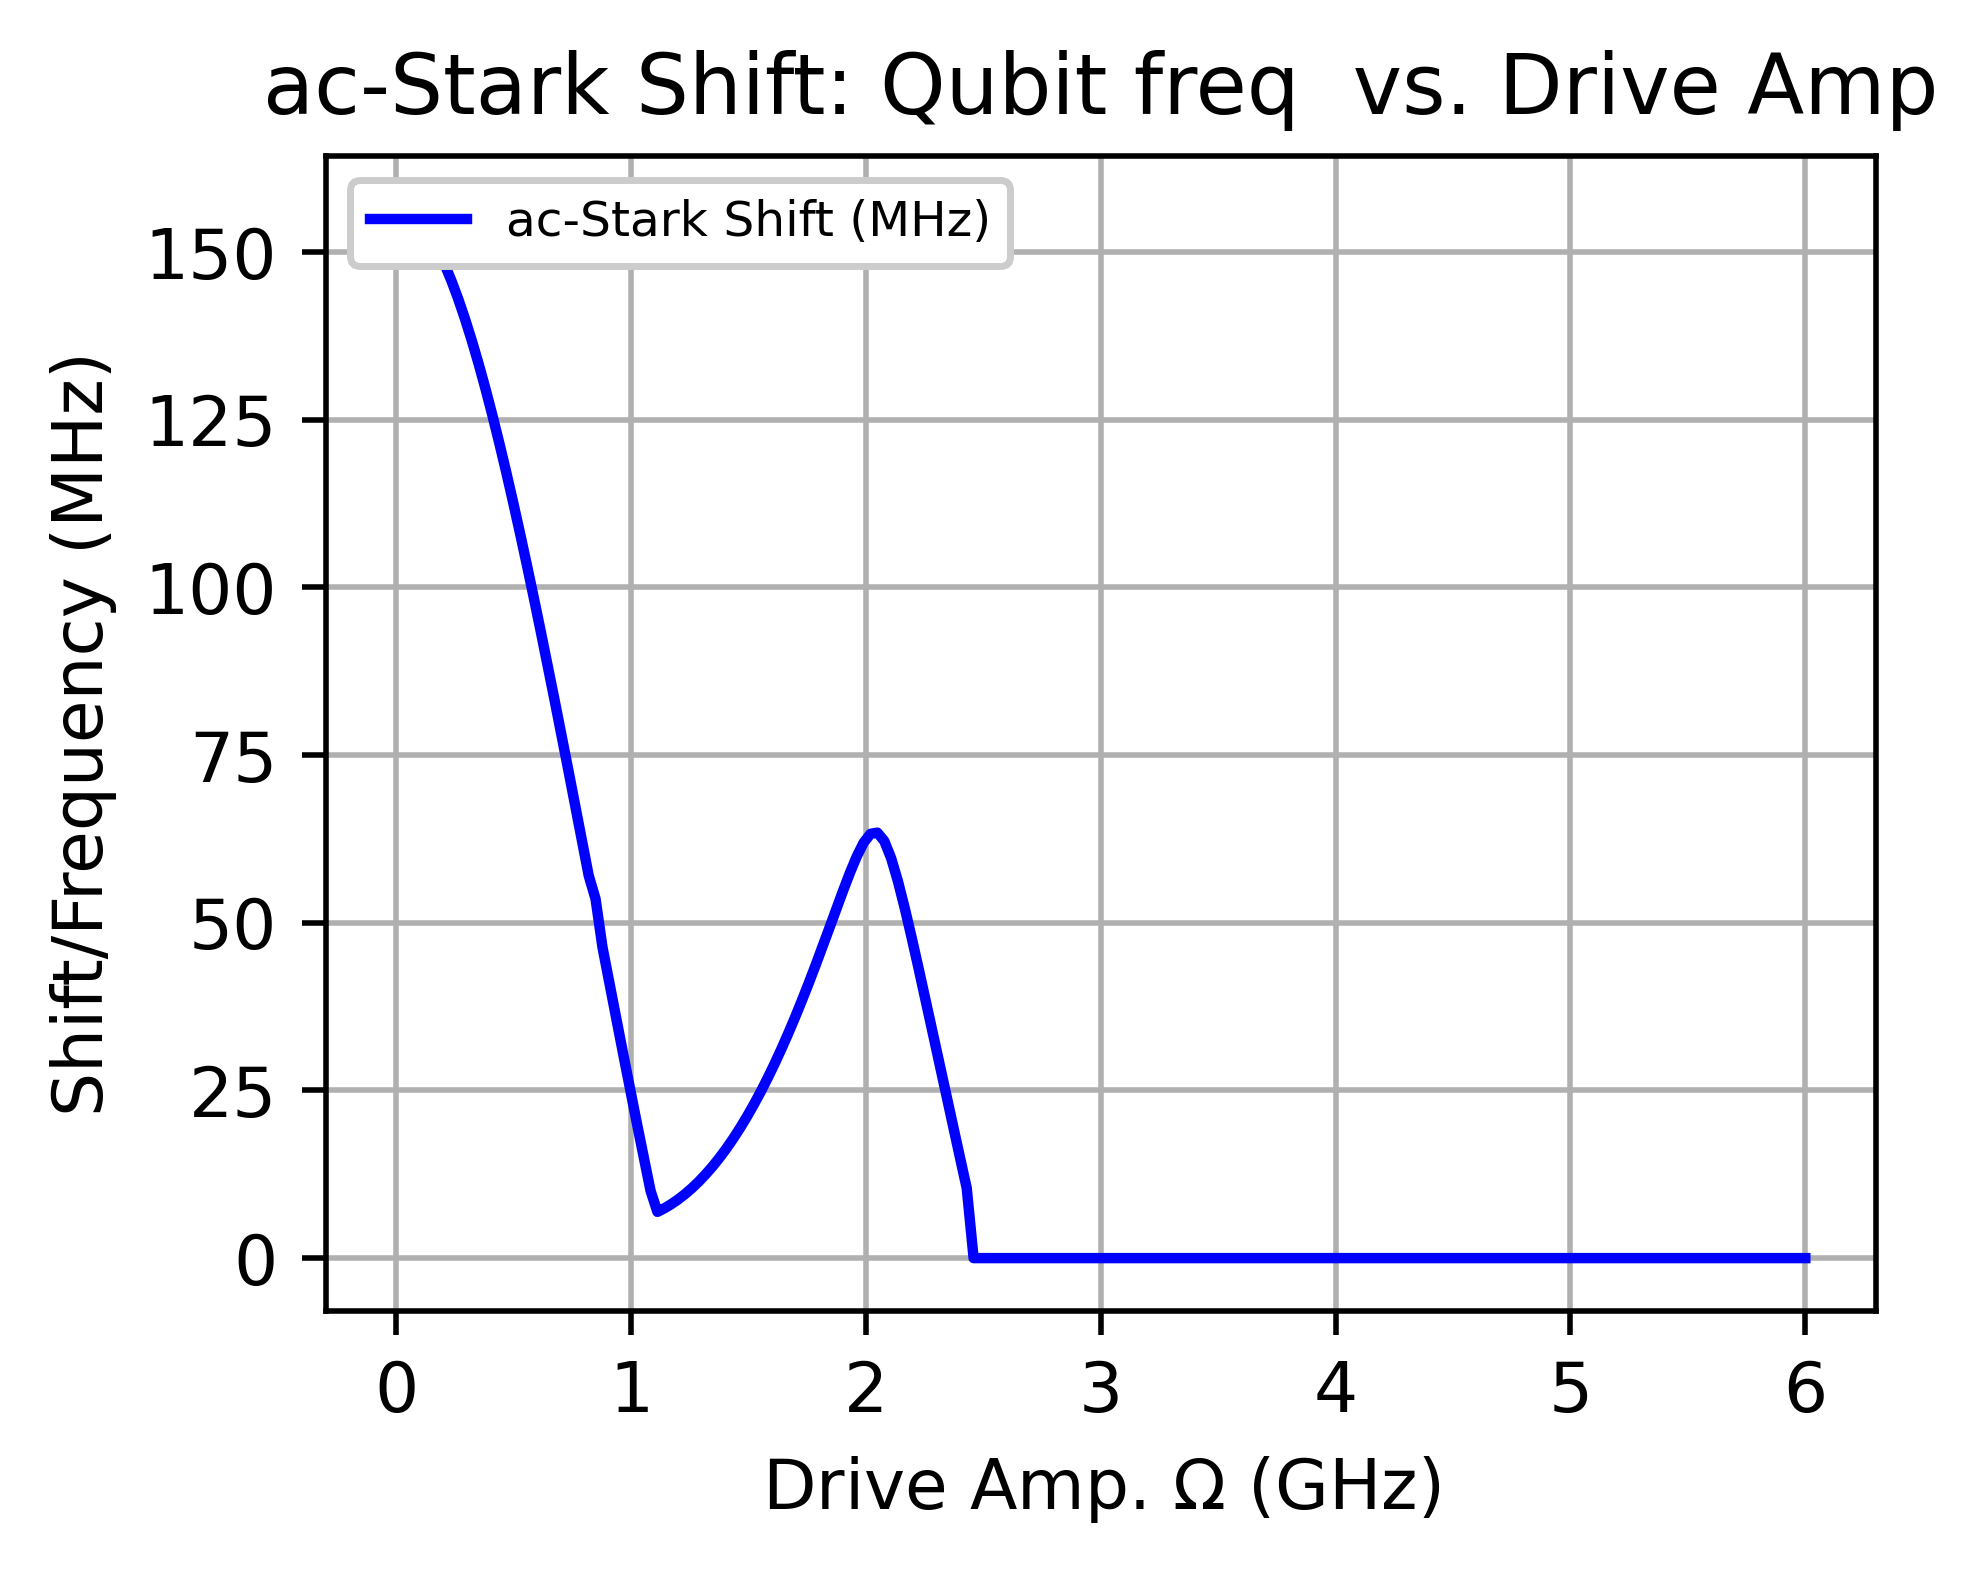

In [263]:
# New plot: ac-Stark shift and anharmonicity
plt.figure(figsize=(4, 3), dpi=500)
plt.plot(drive_amps, ac_stark_shift * 1e3, label=r"ac-Stark Shift (MHz)", color="blue")  # Convert to MHz
# plt.plot(drive_amps, anharmonicity * 1e3, label=r"Anharmonicity (MHz)", color="red")  # Convert to MHz
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Shift/Frequency (MHz)")
plt.title("ac-Stark Shift: Qubit freq  vs. Drive Amp")
plt.legend(loc="upper left", fontsize=7, framealpha=1)
plt.grid(True)
plt.show()

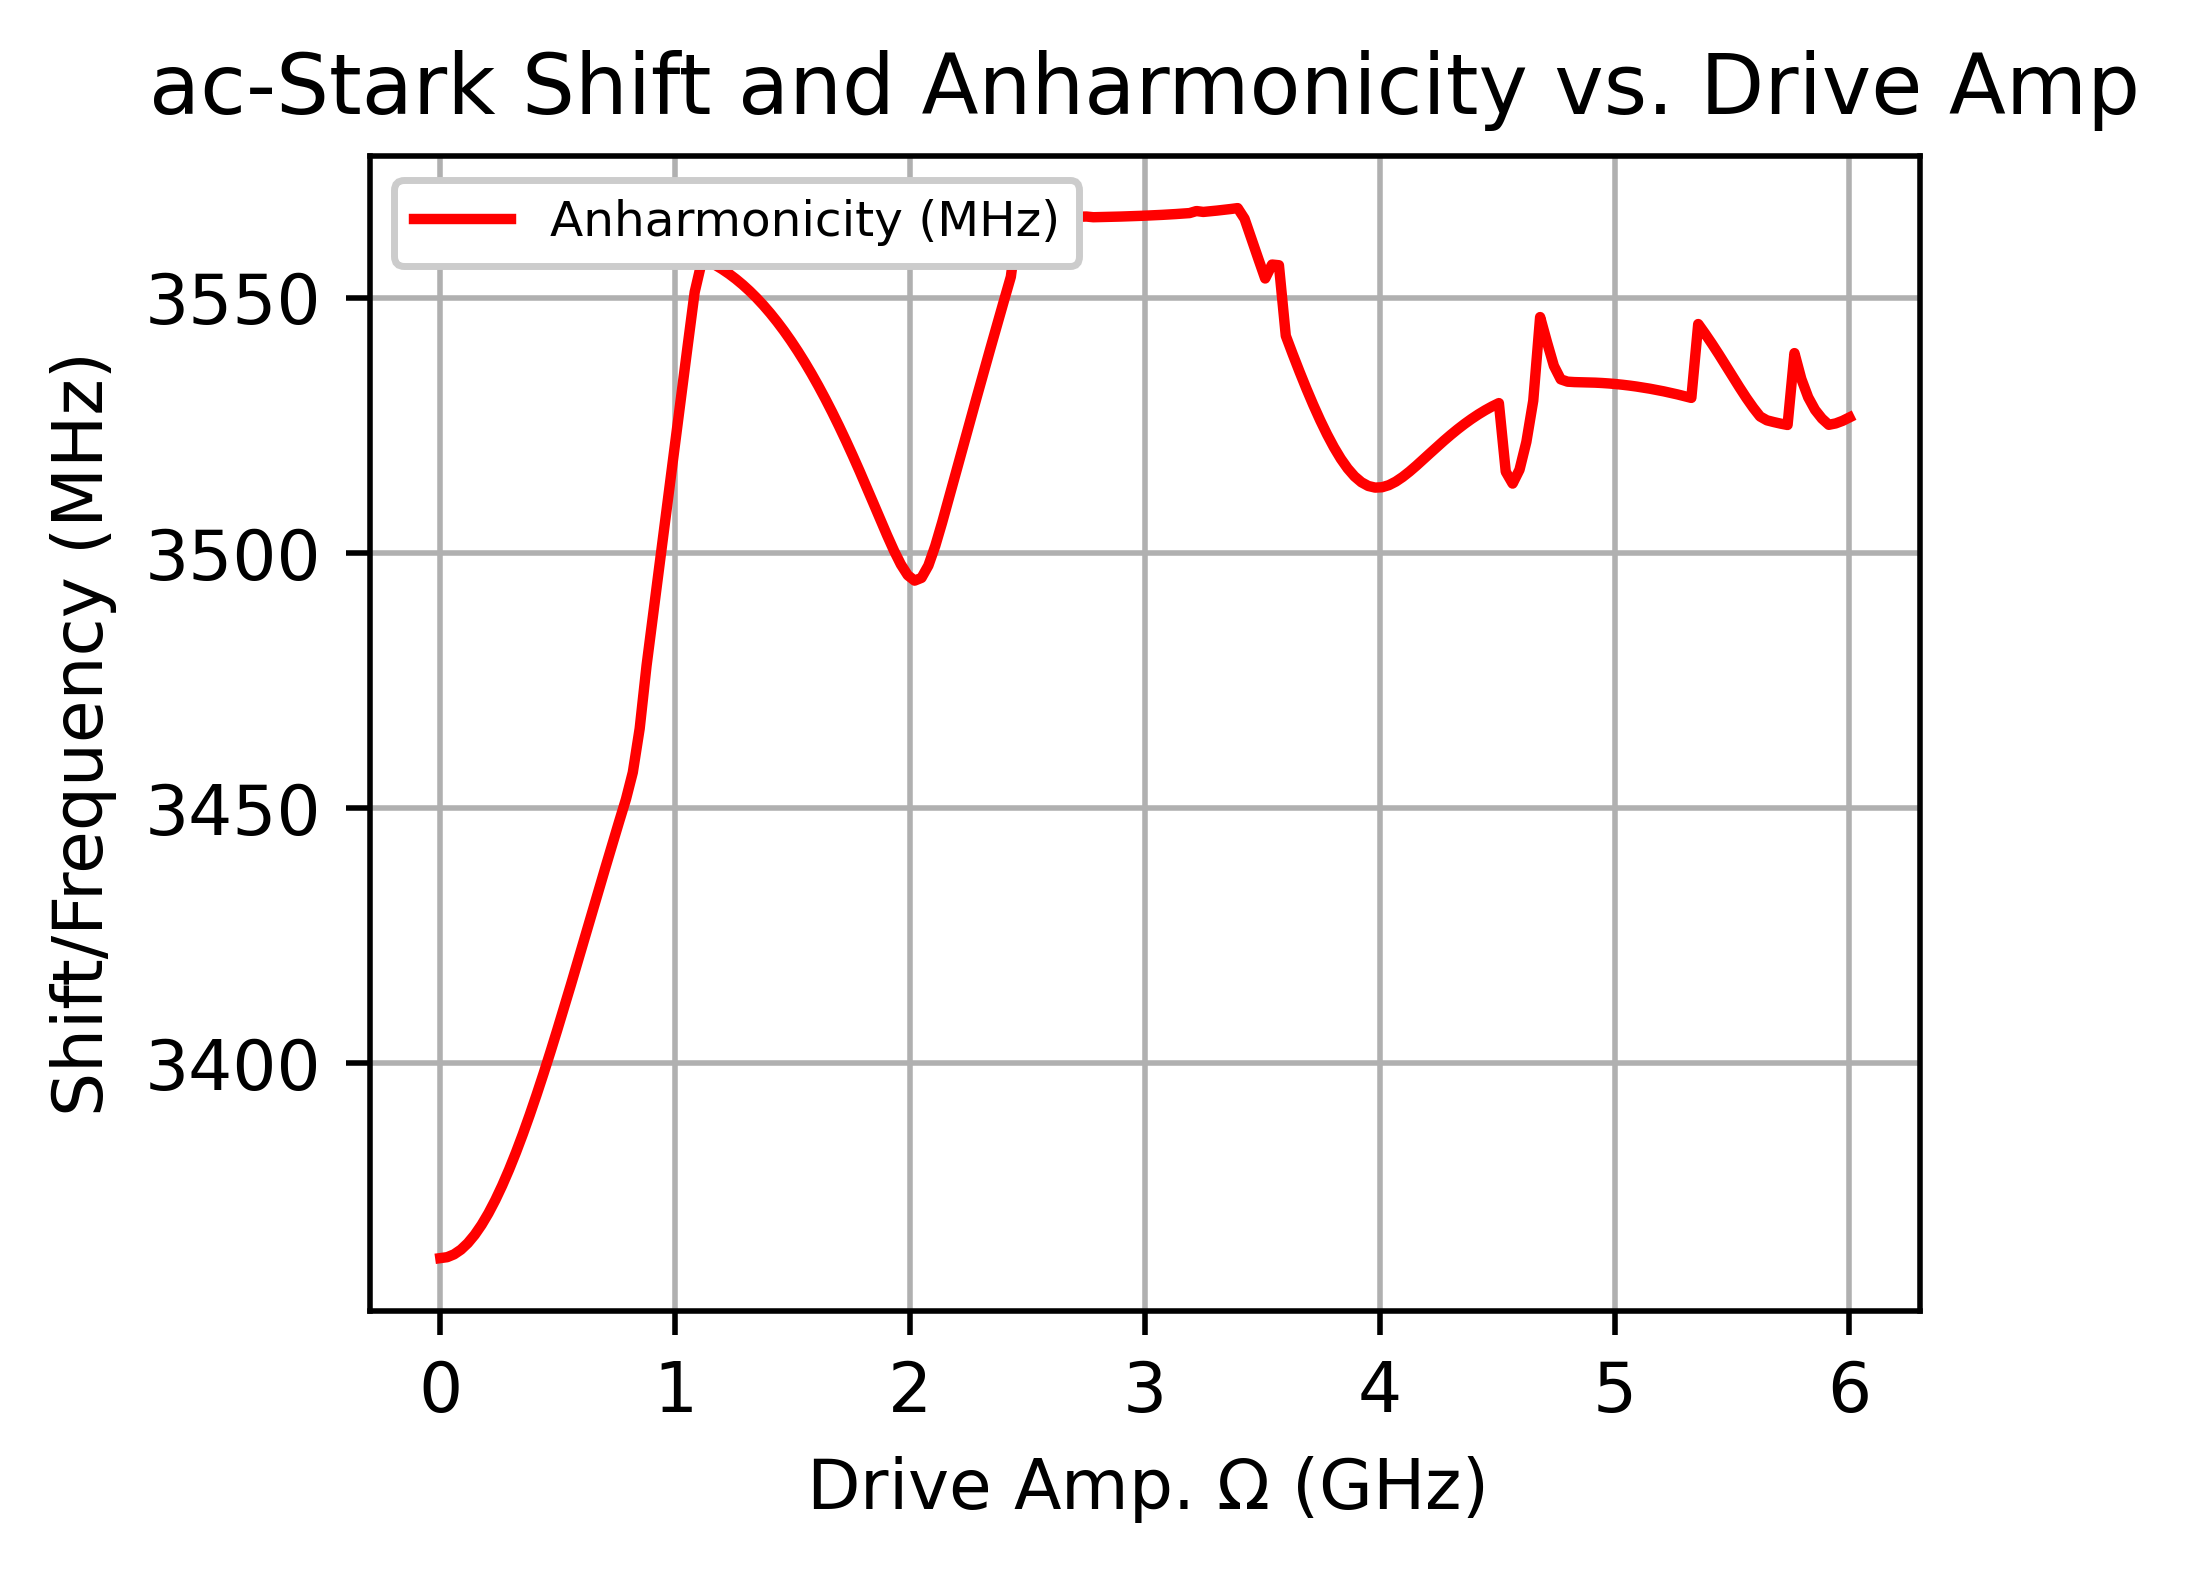

In [264]:
# New plot: ac-Stark shift and anharmonicity
plt.figure(figsize=(4, 3), dpi=500)
# plt.plot(drive_amps, ac_stark_shift * 1e3, label=r"ac-Stark Shift (MHz)", color="blue")  # Convert to MHz
plt.plot(drive_amps, anharmonicity * 1e3, label=r"Anharmonicity (MHz)", color="red")  # Convert to MHz
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Shift/Frequency (MHz)")
plt.title("ac-Stark Shift and Anharmonicity vs. Drive Amp")
plt.legend(loc="upper left", fontsize=7, framealpha=1)
plt.grid(True)
plt.show()

I will trust the code for Fluxonium and move on to coupled system. 